# Imports

In [11]:
from copy import deepcopy
import math
import numpy as np

import project_path
import telomeres.model.parameters as par
import telomeres.dataset.plot as pd
from telomeres.model.plot import plot_laws
import telomeres.population.posttreat as pps
import telomeres.population.plot as pp
import telomeres.population.simulation as sim

# Parameters

## Model parameters

### Default values, quick description

The default *model parameters* are defined by `telomeres.model.parameters.PAR_DEFAULT_POP`. They are not meant to be redefined except to test their sensitivity.

In [14]:
# Import default parameters.
PARAMETERS = deepcopy(par.PAR_DEFAULT_POP)  # Deepcopy ensures that any accidental modification of `PARAMETERS` do not affect `par.PAR_DEFAULT_LIN`.
print(PARAMETERS)

{'is_htype_accounted': True, 'fit': [[0.0247947389, 0.440063202], [[0.186824276, 0.725200993, 27.0], [2.45423414e-06, 0.122028128, 0.0]], [0, 40, 58]], 'p_exit': {'accident': 0.0043, 'death': 0.58, 'repair': 0.65, 'sen_limit': inf}, 'sat': {'choice': ['prop'], 'prop': 1000.0, 'times': {}}}


<br>  
Here is a quick description. For more details, see `telomeres.model.parameters.py` or refer to the article.

* **`PARAMETERS['is_htype_accounted']`: Modeling assumption for *type H* cells**
    - `True` if non-terminally arrested (*type B*) cells can enter senescence (therefore becoming *type H*)
    - `False` otherwise. In this case, *type B* cells must exit their sequence of non-terminal arrests to be allowed to enter senescence  

    In practice, `PARAMETERS['htype']` is always `True` and should thus be removed from the code (remnant of the first code version).

* **`PARAMETERS['fit']`: Fitted parameters**  
    - **Laws for arrest onset** (plotted below):  
        + $p_{nta} (\ell) = \min(1, b e^{-a \ell})$, with $(a, b) = (a_{nta}, b_{nta}) =$ `PARAMETERS['fit'][0]`
        + $p_{sen_A} (\ell) = \min(1, b e^{-a \ell} + 1_{\ell \leq \ell_{min}})$, with $(a, b, \ell_{min}) = (a_{sen_A}, b_{sen_A}, \ell_{min_A}) = $ `PARAMETERS['fit'][1][0]`
        + $p_{sen_B} (\ell) = \min(1, b e^{-a \ell} + 1_{\ell \leq \ell_{min}})$, with $(a, b, \ell_{min}) =  (a_{sen_B}, b_{sen_B}, \ell_{min_B}) = $ `PARAMETERS['fit'][1][1]`.
     
        <br>
    
    - **Transformation of the initial distribution of telomere length** (see article):  
        + $(\ell_{trans}, \ell_0, \ell_1) = $ `PARAMETERS['fit'][2]`.

        <br>
* **`PARAMETERS['p_exit']`: Parameters for the "exit" of a cycle**
    - `PARAMETERS['p_exit']['accident']`: Rate of accidental death $p_{accident}$  
    - `PARAMETERS['p_exit']['death']` $= p_{death}$   
    - `PARAMETERS['p_exit']['repair']` $= p_{repair}$
    - `PARAMETERS['p_exit']['sen_limit']`: Maximum number of senescent cycles (`math.inf` for no limit).

        <br>
* **`PARAMETERS['sat']`: Parameters to describe saturation**
    - `PARAMETERS['sat']['choice'][i]`: Saturation rule on day `i`:
        + `'time'` if saturation is reached (i.e., population evolution is stopped until dilution) at a certain time $t_{sat,i}$
        + `'prop'` if saturation is reached when cell concentration exceeds a certain number of cells $N_{sat} \coloneqq r_{sat} \times N_{init}$, where $N_{init}$ is the initial number of cells (or equivalently, the number of cells after dilution).
        +  If `PARAMETERS['sat']['choice'][-1]` is `'prop'`, this option applies from day `len(SAT_CHOICE)` to the end.
    - `PARAMETERS['sat']['prop']` $= r_{sat}$
    - `PARAMETERS['sat']['times'][i]` $= t_{sat,i}$
      
> **Example 1:** For the rule `'time'` (times of saturation) on days 1 and 2, and the rule `'prop'` (concentration of saturation) from day 3 onwards, use:

In [17]:
parameters_sat = {'choice': ['time', 'time', 'prop'],  # Rule 'time' on days 1 and 2 and rule 'prop' from day 3 onwards.
                  'prop': 1e3,  # Value of r_sat used for days 3, 4, ...
                  'times': {0: 0.6045 * 24 * 60,  # t_{sat,1} saturation time on day 1.
                            1: 1.6267 * 24 * 60}}  # t_{sat,2} saturation time on day 2.

> **Example 2.** Describe the default rule.

In [20]:
print(PARAMETERS['sat'])

{'choice': ['prop'], 'prop': 1000.0, 'times': {}}


> Each day, saturation is reached when the number of cells becomes $1000$ times the initial number of cells.

### Graphical representation.

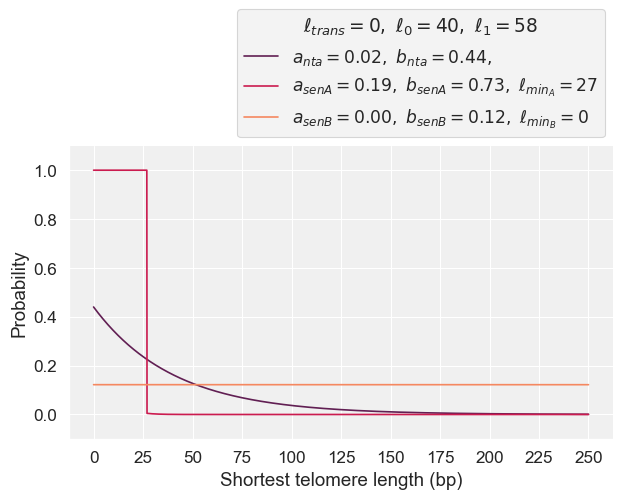

In [24]:
# Plot the laws for the onset of arrests.
# - Set `is_par_plot` to True for the parameters (rounded to a precision of 10e-2) to be plotted.
# - Adjust the spacing of the x-ticks using `tick_spacing`.
plot_laws(PARAMETERS['fit'], is_par_plot=True, tick_spacing=25)


 Distribution of telomere lengths: 
 ---------------------------------
Average initial length: 316 +/- 102
Median initial length: 301 +/- 103
Mode: 260 +/- 116
Support of distribution fonction: [73,1058]
int L_init(x) dx:  0.9999999999999998
Last values of <L_init_prob>:  [8.26296178e-09 5.99929752e-09 5.85456994e-09 5.71333709e-09]


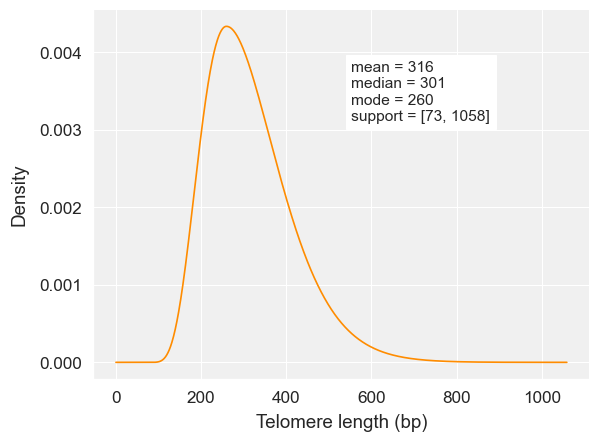

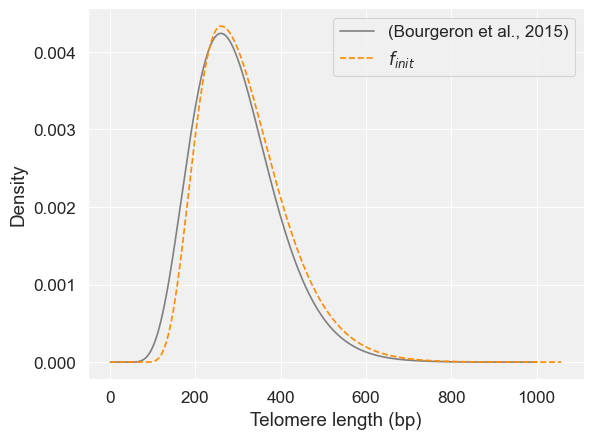

In [26]:
# Plot the distribution of initial telomere lengths.
# - Set `is_par_plot` to True for the parameters (rounded to a precision of 10e-2) to be plotted.
# - Adjust the spacing of the x-ticks using `tick_spacing`.
PAR_L_INIT = PARAMETERS['fit'][2]
LABELS = ["(Bourgeron et al., 2015)", r'$f_{init}$']
FIG_DIR = None
pd.plot_ltelomere_init(FIG_DIR, par_l_init=PAR_L_INIT, labels=LABELS)

### Update of default parameters

Only possible updates of the default parameters (`PARAMETERS = par.PAR_DEFAULT_POP`) are passed to most of the functions of the code through the `par_update` argument. The reason, is that default parameters are generally not intended to be changed.

By default, `par_update` is `None`, meaning that the model parameters remain exactly as the default ones.
When updates are needed, `par_update` should be a dictionary containing the keys from `par.PAR_DEFAULT_POP` that need to be updated, along with their corresponding updated values.

> **Example 1: Update of $p_{accident}$ only.** Although a bit laborious, one must update the `'p_exit'` key of the model parameters (see Section 1.1.), which is a dictionary, by initializing it with a new dictionary where only the `'accident'` key has been modified:

In [29]:
# Definition of `par_update` corresponding to an update of `p_accident` only.
P_ACC_NEW = 5  # New value for p_accident.

P_EXIT_DEFAULT = par.PAR_DEFAULT_POP['p_exit']  # Default 'p_exit' key of default model parameters.
P_EXIT_NEW = deepcopy(P_EXIT_DEFAULT)
P_EXIT_NEW['accident'] = P_ACC_NEW

PAR_UPDATE = {'p_exit': P_EXIT_NEW}

> **Example 2. Update of parameter $\ell_{minB}.$** Through the `'fit'`key.

In [32]:
# Definition of `par_update` corresponding to an update of `lmin_B`.
LMIN_B_NEW = 10  # New value.

FIT_NEW = deepcopy(par.PAR_DEFAULT_POP['fit'])  # Default 'fit' key of default model parameters.
FIT_NEW[1][1][2] = LMIN_B_NEW
PAR_UPDATE = {'fit': FIT_NEW}

> **Example 3. Both previous updates.**

In [35]:
PAR_UPDATE = {'p_exit': P_EXIT_NEW, 'fit': FIT_NEW}

## Simulation parameters

The default *simulation parameters* are defined by `telomeres.model.parameters.PAR_DEFAULT_SIM_POP`.
As default parameters, they are not meant to be redefined.


In [38]:
PARAMETERS_SIM = deepcopy(par.PAR_DEFAULT_SIM_POP)
print(PARAMETERS_SIM)

{'day_count': 20, 't_day_count': 200, 'tsaved_day_count': 150, 'step': 0.001}


These parameters decribe the **time axis (in days)**. It is defined by $[0, dt, \dots, 1-dt, 1-\varepsilon, 1, 1+dt, \dots, N-dt, N-\varepsilon, N, N+dt, \dots, N+1-dt, N+1-\varepsilon, N+1]$, where:

- **`PARAMETERS_SIM['day_count']` $= N$**: Maximum duration of the experiment (in days), or equivalently, the number of dilutions *+ 1*.

- **`PARAMETERS_SIM['tsaved_day_count']` $= \frac{1}{dt} + 1$**: Number of time points computed between two consecutive dilutions, excluding the (also computed) time $t_{dil} - \varepsilon$. This must be at least $\frac{6 \times 24}{\verb'CYCLE_MIN'}$
- **`PARAMETERS_SIM['tsaved_day_count']`**: Number of time points saved between two consecutive dilutions, excluding the (also saved) time $t_{dil} - \varepsilon$
- **`PARAMETERS_SIM['step']`$= \varepsilon \in (0, dt)$**.

> **Remark.** "Artificial" times are added before each dilution to track the population right before dilution (at $n - \varepsilon \approx n^-$, for $n \in \mathbb{N}^*$) and right after (at day $n = n^+$).

For more details, see `telomeres.model.parameters.py`.

# Simulation and Plot

## One Simulation

To simulate the evolution of a population over daily dilutions, specify the following in addition to any updates to the default parameters:

- **`CELL_COUNT` $= N_{init} \,$.** The initial number of cells (which is also the number of cells retained after each dilution).
- **`PARA_COUNT`.** The number of parallelizations to use for computing the population evolution over each day: each day, the population is divided into `PARA_COUNT` subpopulations that evolve independently in parallel; at the end of the day, these subpopulations are merged, and the entire population is diluted. The process is then repeated for the next day, with the population being subdivided again, and so on.  As much as possible, avoid parallelizing to prevent parallelization bias in the simulation (unless you intend to use this bias to study competition and selection effects).



In [43]:
# Required parameters.
PARA_COUNT = 1  # No parallelization.
CELL_COUNT = 12  # Initial number of cells.

# Simulation of one population with default parameters.
# Remark 1. Default of updates being already `None`, `sim.simu_parallel(PARA_COUNT, CELL_COUNT)` is equivalent.
# Remark 2. If you run the cell a 2nd time, simulation will run again since it was not saved the 1st time.
out = sim.simu_parallel(PARA_COUNT, CELL_COUNT, par_update=None, par_sim_update=None)

Day n° 1 c_last 12
Day n° 2 c_last 12.0
Day n° 3 c_last 12.0
Day n° 4 c_last 12.0
Day n° 5 c_last 12.0
Day n° 6 c_last 12.0
Day n° 7 c_last 11.0
Day n° 8 c_last 1.0


### Saving

**Remark:** In the lineage case, a single simulation is not saved automatically; only statistics from multiple simulations are saved. As simulating the evolution of a single population is more computationally intensive than simulating a hundred lineages, you may want to request that the output be saved by specifying this in the arguments. To do so, provide an index to label the output.

In [47]:
import time  # Time module to measure computation time.

# Same simulation, now saving the results.
OUTPUT_INDEX = 1  # This is the first simulation saved, assign it index 1.
time_start = time.time()
out = sim.simu_parallel(PARA_COUNT, CELL_COUNT, output_index=OUTPUT_INDEX)
time_end = time.time()

print("\n Computation time: ", time_end - time_start)

Day n° 1 c_last 12
Day n° 2 c_last 12.0
Day n° 3 c_last 12.0
Day n° 4 c_last 12.0
Day n° 5 c_last 12.0
Day n° 6 c_last 12.0
Day n° 7 c_last 11.0
Day n° 8 c_last 12.0
Day n° 9 c_last 8.0
Day n° 10 c_last 4.0
Day n° 11 c_last 4.0
Saved at:  /home/anais/Documents/python/telomeres/simulations/population/parNTA0.0247947389-0.440063202_parSENA0.186824276-0.725200993-27_parSENB2.45423414e-06-0.122028128-0/psat1000/pdeath0.0043-0.58_prepair0.65/linit0-40-58/cell_12/para_1/output_01.npy

 Computation time:  7.961956024169922


In [49]:
# Remark. If run again, the output is not re-simutated but only loaded, which is faster.
time_start = time.time()
out = sim.simu_parallel(PARA_COUNT, CELL_COUNT, output_index=OUTPUT_INDEX)
time_end = time.time()

print('\n "Computation" time: ', time_end - time_start)

Loaded from:  /home/anais/Documents/python/telomeres/simulations/population/parNTA0.0247947389-0.440063202_parSENA0.186824276-0.725200993-27_parSENB2.45423414e-06-0.122028128-0/psat1000/pdeath0.0043-0.58_prepair0.65/linit0-40-58/cell_12/para_1/output_01.npy

 "Computation" time:  0.010983705520629883


### Output Structure

The output of the simulation is a dictionary containing detailed information outlined below:

- **Time Evolution Arrays.** These entries provide information about the population at every saved time point (`times`). If the population is extinct at a given time, `np.nan` values are returned.
    +  **1D Arrays (shape: `time_count,`):**
        * **`'times'`** : Array of shape `(time_count,)` representing the saved times (in days), defined based on `par_sim_update`.
        * **`'evo_lavg_sum'`, `'evo_lmin_sum'`** : Temporal evolution of the sum of cells' average (shortes, resp.) telomere lengths.
        * **`'evo_lmin_max'`, `'evo_lmin_min'`** : Temporal evolution of the longest (shortest, resp.) cells' shortest telomere lengths.
        * **`'evo_lmode'`** : Temporal evolution of the mode in the distribution of telomere lengths.
       
       <br>
    + **2D Arrays (shape: `time_count, X`):**
        * **`'evo_c_ancs'`** : Temporal evolution of the number of cells with respect to their ancestor in the original population (the 2nd dimension `X = ancestor_count` refers to the ancestor index). Idem with only the number of *type B* cells (`'evo_c_B_ancs'`), senescent cells ('`evo_c_sen_ancs'`), etc. (`'evo_c_B_sen_ancs'`, `'evo_c_H_ancs'`).
        * **`'evo_c_gens'`** : Temporal evolution of the distribution of generations in the population (`X = generation_max + 1`).

    <br>
- **Initial Population Data.** This entry contains the data from the population at the start of the simulation:
    + **`'day_init_data'`** : A dictionary containing data on the initial population, with entries for `'ancestors'`, `'nta_counts'`, `'clocks'`, `'generations'`, and `'sen_counts'`.

    <br>
- **Population History.** These entries track the population’s history over time, including key events such as saturation, extinction, and individual cell death.

    + **`'sat_time'`** : The daily saturation times in days, exact (`para_count=1`) or average (on all subpopulations that have saturated) (`para_count>1`) value. `NaN` values are returned for days where no saturation reached.
    + **`'sat_prop'`** : The daily proportion of subpopulations that have reached saturation.
    + **`'history_dead'`** : An array of shape `(dead_cell_count, 4)` that records data on each dead cell. Each entry contains the ancestor, generation, time of death (in days), and the type of the dead cell.
    + **`'extinction_time'`** : The time of population extinction (in days). `math.inf` if the population does not go extinct.
    + **`'evo_lmin_gsen'`** : A dictionary with entries `'atype'`, `'btype'`, etc., each consisting of `day_count` lists of `tsaved_per_day_count` such that `out['evo_lmin_gsen']['atype'][i][j]` is the list of telomere lengths that triggered senescence in *type A* cells at the `j`th time point of the `i`th day.

    <br>
- **Computation Resources.**
    + **`'memory'`** : The amount of memory (in bytes) used during one day of simulation (only for `para_count=1`).
    + **`'computation_time'`** : The total computation time (in minutes).


In [52]:
print(out.keys())

dict_keys(['day_init_data', 'evo_c_ancs', 'evo_c_B_ancs', 'evo_c_B_sen_ancs', 'evo_c_sen_ancs', 'evo_c_H_ancs', 'evo_lavg_sum', 'evo_lmin_sum', 'evo_c_gens', 'evo_lmin_max', 'evo_lmin_min', 'evo_lmode', 'history_dead', 'evo_lmin_gsen', 'sat_time', 'sat_prop', 'memory', 'extinction_time', 'times', 'computation_time'])


### Post-treatment

Additional information can be derived from the previous simulation. For example:
- Total **number of cells** through time, `'evo_c'`, as well as `'evo_c_sen'` `'evo_c_B'` `'evo_c_B_sen'`, etc.
- Evolution of the **proportions of cells** with specific characteristics `'evo_p_*'` (from the associated cell counts `'evo_c_*'` and the total `'evo_c'`)
- Population average `'evo_lavg_avg'`, `'evo_lmin_avg'` of cells' average and shortest telomere length (rather than sums `'evo_lavg_sum'`, `'evo_lmin_sum'`)
- **Histograms** of telomere lengths triggering senescence `'hist_lmin_*'` (rather than lists telomere lengths, `'evo_lmin_gsen'`).

All of this can be achieved by applying `pps.postreat_from_evo_c` on an already saved simulation. This will create 


In [58]:
# The previously saved simulation is uniquely defined by `PARA_COUNT`, `CELL_COUNT`, `OUTPUT_INDEX`
# and the default parameters (`par_update` equal to None).
# We posttreat it using:
out_processed = pps.postreat_from_evo_c(PARA_COUNT, CELL_COUNT, OUTPUT_INDEX)

This function generates a file named `output_01_p_from_c.npy`, which contains the post-treated data, saved alongside the original simulation output file, `output_01.npy` (located in the directory uniquely specified by `telomeres.auxiliary.write_paths.write_simu_pop_subdirectory(CELL_COUNT, PAR_COUNT, par_update=None)`).


In [61]:
print(out_processed.keys())

dict_keys(['evo_c', 'evo_c_sen', 'evo_p_ancs', 'evo_c_B', 'evo_p_B_ancs', 'evo_p_B', 'evo_c_B_sen', 'evo_p_B_sen_ancs', 'evo_p_B_sen', 'evo_p_sen_ancs', 'evo_p_sen', 'evo_c_H', 'evo_p_H_ancs', 'evo_p_H', 'evo_p_H_sen_ancs', 'evo_p_H_sen', 'evo_p_gen', 'evo_lavg_avg', 'evo_lmin_avg', 'hist_lmin_all', 'hist_lmin_per_day'])


## Several simulations with same parameters

The next step consists in simulating `SIMULATION_COUNT` times the (stochastic) evolution of a population, using the exact same parameters.
This approach enable the calculation of average or extreme values across all simulations.

### A requirement: saving and processing

To do so, execute the previous steps either sequentially or in parallel, for example, using a cluster (see the `main.population.compute.py` and `main.population.slurm_compute.batch` files).

In [64]:
# Sequential computation with a small number of simulations and initial cells.
PARA_COUNT = 1  # Each simulation is run without parallelization on each day.
CELL_COUNT = 12  # Initial number of cells.
SIMULATION_COUNT = 5  # Number of times the simulation is run.

for idx_sim in range(1, SIMULATION_COUNT + 1):  # Run the `SIMULATION_COUNT` simulations sequentially.
    # Print simulation index to keep track of computation progress.
    print('\n', f'Simulation n° {idx_sim}/{SIMULATION_COUNT}')

    # Simulation and saving of the `idx_sim`-th simulation.
    # Note: No `par_update` and `par_sim_update` specified => default parameters used.
    sim.simu_parallel(PARA_COUNT, CELL_COUNT, output_index=idx_sim)
                
    # Post-treatment.
    pps.postreat_from_evo_c(PARA_COUNT, CELL_COUNT, idx_sim)


 Simulation n° 1/5
Loaded from:  /home/anais/Documents/python/telomeres/simulations/population/parNTA0.0247947389-0.440063202_parSENA0.186824276-0.725200993-27_parSENB2.45423414e-06-0.122028128-0/psat1000/pdeath0.0043-0.58_prepair0.65/linit0-40-58/cell_12/para_1/output_01.npy

 Simulation n° 2/5
Day n° 1 c_last 12
Day n° 2 c_last 12.0
Day n° 3 c_last 12.0
Day n° 4 c_last 12.0
Day n° 5 c_last 12.0
Day n° 6 c_last 12.0
Day n° 7 c_last 12.0
Saved at:  /home/anais/Documents/python/telomeres/simulations/population/parNTA0.0247947389-0.440063202_parSENA0.186824276-0.725200993-27_parSENB2.45423414e-06-0.122028128-0/psat1000/pdeath0.0043-0.58_prepair0.65/linit0-40-58/cell_12/para_1/output_02.npy

 Simulation n° 3/5
Day n° 1 c_last 12
Day n° 2 c_last 12.0
Day n° 3 c_last 12.0
Day n° 4 c_last 12.0
Day n° 5 c_last 12.0
Day n° 6 c_last 12.0
Day n° 7 c_last 6.0
Day n° 8 c_last 2.0
Saved at:  /home/anais/Documents/python/telomeres/simulations/population/parNTA0.0247947389-0.440063202_parSENA0.18682

### Statistics on all simulations

#### Performances

In [67]:
# Compute statistics on the performances of all the simulations.
out_p = pps.postreat_performances(PARA_COUNT, CELL_COUNT, SIMULATION_COUNT)
print('Keys of `postreat_performances` output: \n', list(out_p.keys()))

# Print them.
print("\nStatistics on computation time (min): \n out_p['computation_time'] =", out_p['computation_time'])    
print("\nStatistics on computational ressource, memory (Mo): \n out_p['memory_in_mo'] =", out_p['memory_in_mo'])    

Keys of `postreat_performances` output: 
 ['computation_time', 'memory', 'memory_in_mo']

Statistics on computation time (min): 
 out_p['computation_time'] = {'mean': 0.1266323161125183, 'std': 0.008988336045274561, 'perup': 0.13460105260213215, 'perdown': 0.11128148357073465, 'min': 0.10967381397883097, 'max': 0.13484704097112019}

Statistics on computational ressource, memory (Mo): 
 out_p['memory_in_mo'] = {'mean': 37.6133632, 'std': 0.3337647220989052, 'perup': 37.7876992, 'perdown': 37.028608, 'min': 36.94592, 'max': 37.78816}


#### Time evolution data

In [70]:
# Compute statistics on the simulation time evolution data.
# This step can take long...
out_s = pps.statistics_simus(PARA_COUNT, CELL_COUNT, SIMULATION_COUNT)
print(out_s.keys())


Data processing...
evo_c_ancs
evo_c_B_ancs
evo_c_B_sen_ancs
evo_c_sen_ancs
evo_c_H_ancs
evo_p_ancs
evo_p_B_ancs
evo_p_B_sen_ancs
evo_p_sen_ancs
evo_p_H_ancs
evo_p_H_sen_ancs
evo_c_gens
evo_c
evo_c_B
evo_c_B_sen
evo_c_sen
evo_c_H
evo_p_H_sen
evo_p_B
evo_p_H_sen
evo_p_B_sen
evo_p_H_sen
evo_p_sen
evo_p_H_sen
evo_p_H
evo_p_H_sen
dict_keys(['extinction_time', 'times', 'sat_time', 'sat_prop', 'sen_time', 'evo_c_ancs_lavg', 'evo_c_ancs', 'evo_c_B_ancs_lavg', 'evo_c_B_ancs', 'evo_c_B_sen_ancs_lavg', 'evo_c_B_sen_ancs', 'evo_c_sen_ancs_lavg', 'evo_c_sen_ancs', 'evo_c_H_ancs_lavg', 'evo_c_H_ancs', 'evo_p_ancs_lavg', 'evo_p_ancs', 'evo_p_B_ancs_lavg', 'evo_p_B_ancs', 'evo_p_B_sen_ancs_lavg', 'evo_p_B_sen_ancs', 'evo_p_sen_ancs_lavg', 'evo_p_sen_ancs', 'evo_p_H_ancs_lavg', 'evo_p_H_ancs', 'evo_p_H_sen_ancs_lavg', 'evo_p_H_sen_ancs', 'evo_c_gens', 'evo_c', 'evo_c_B', 'evo_c_B_sen', 'evo_c_sen', 'evo_c_H', 'evo_p_H_sen', 'evo_p_B', 'evo_p_B_sen', 'evo_p_sen', 'evo_p_H', 'evo_lavg_avg', 'evo_lmin_av

### Plot

**Warning.** Plotting parameters should be adjusted for better results. See `main.population.plot.py` for such parameterization.

#### Histograms of telomere length triggering senescence

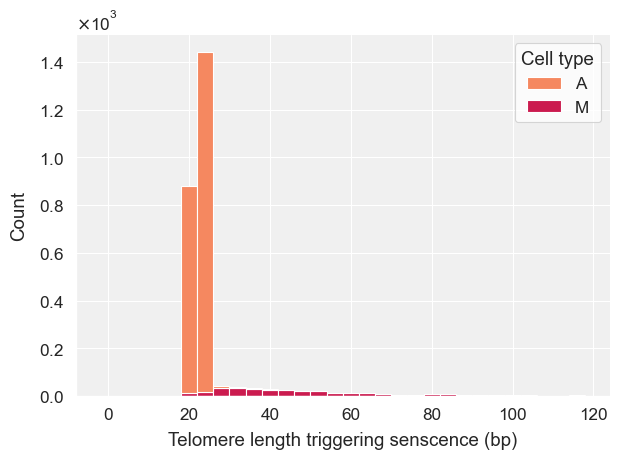

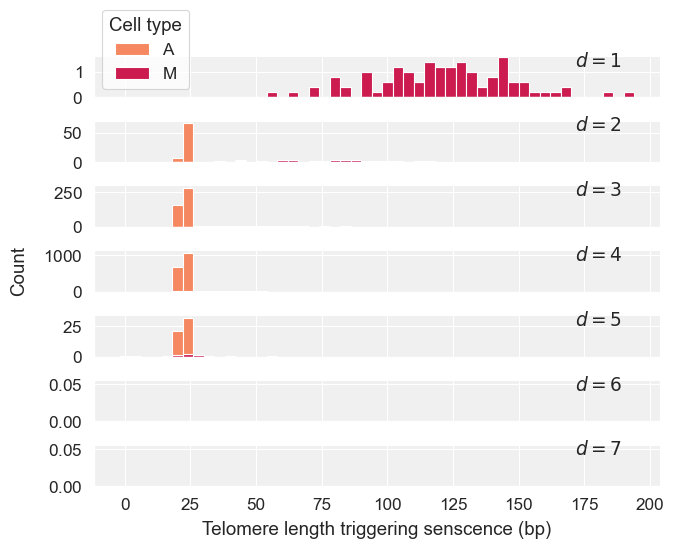

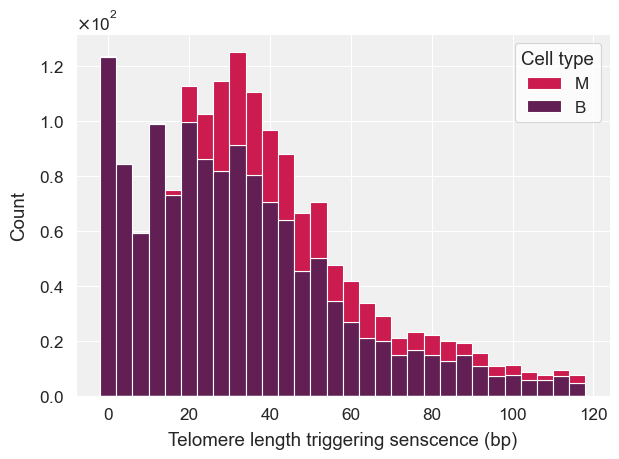

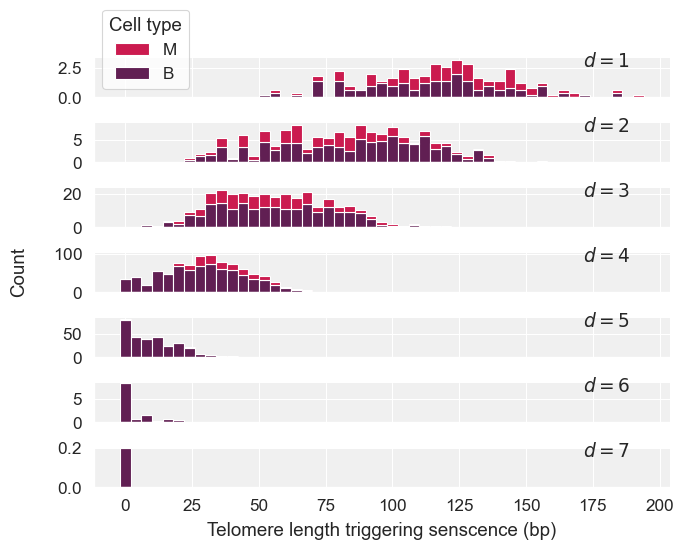

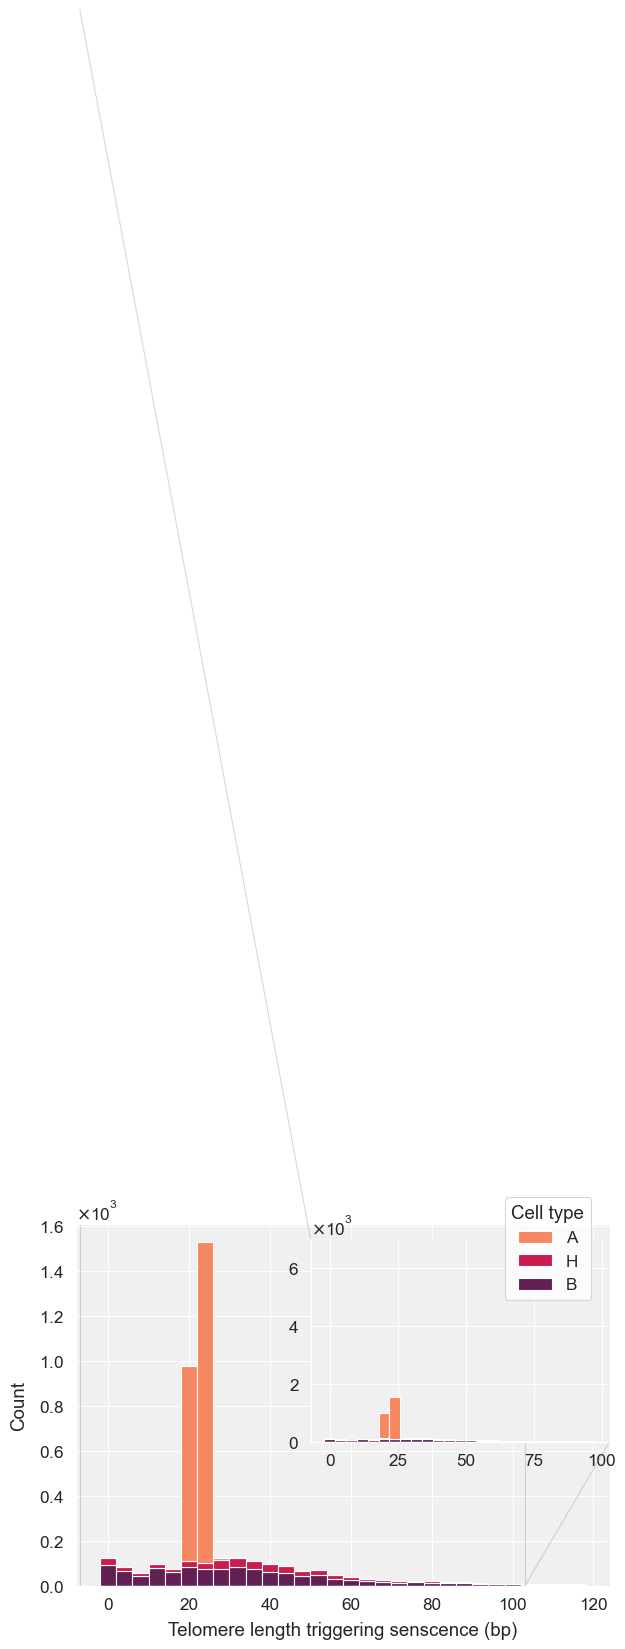

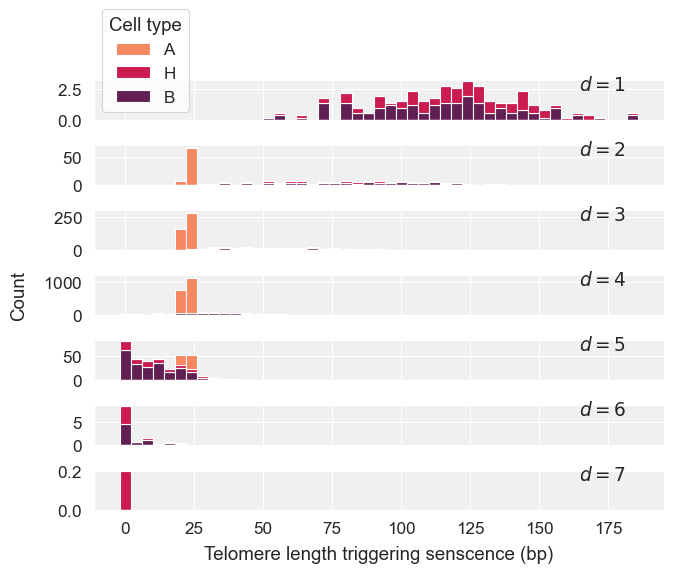

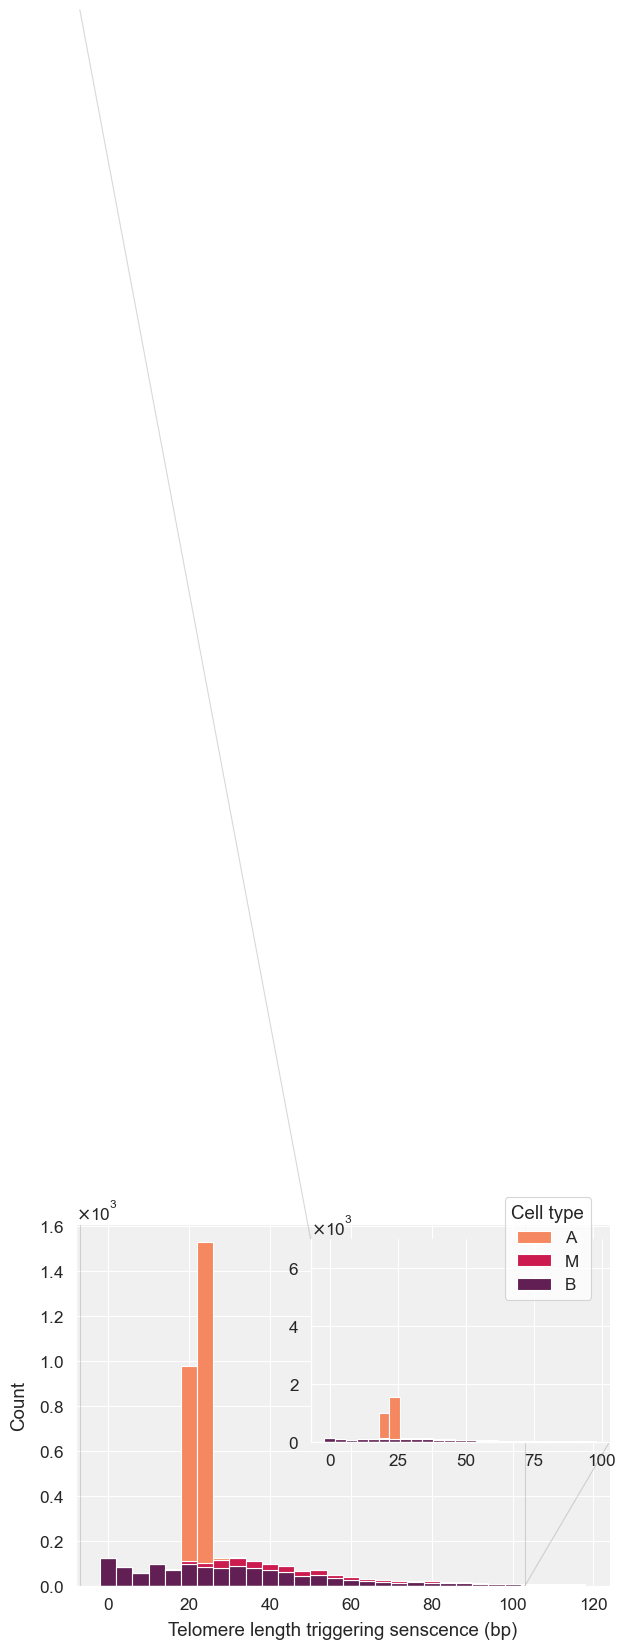

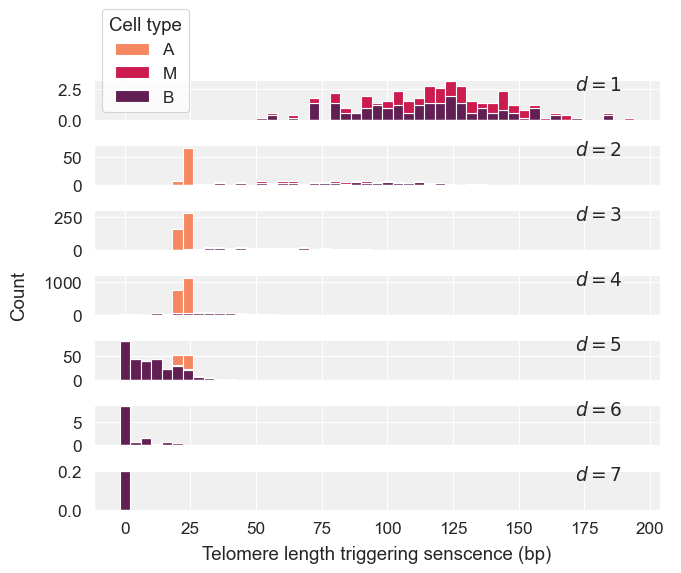

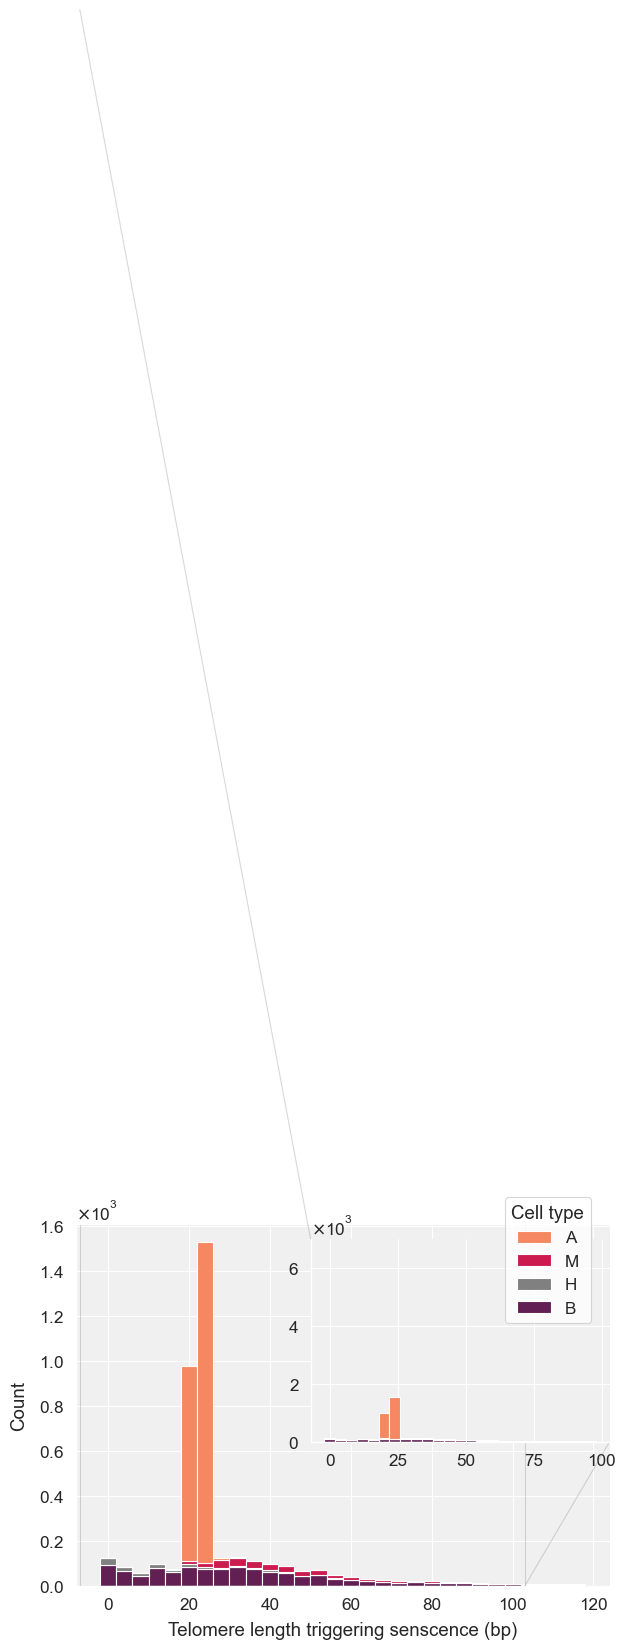

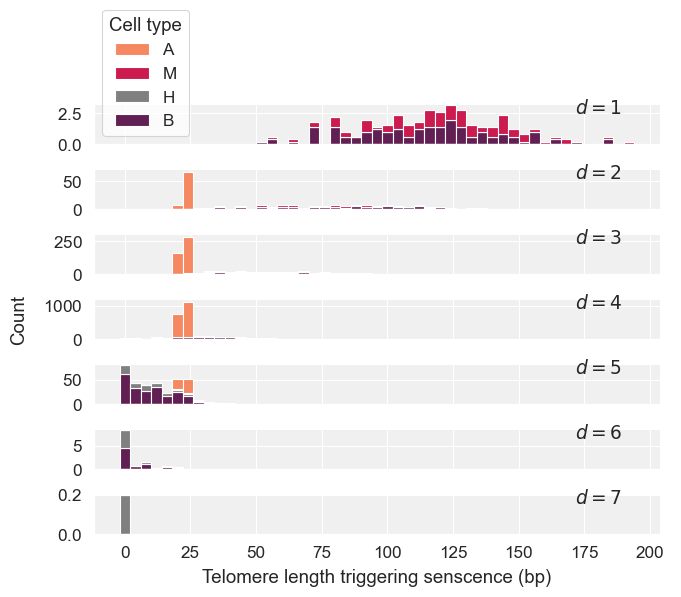

In [73]:
# Plot average on simulations run at `CELL_COUNT` and `PARA_COUNT` fixed.
FIG_DIRECTORY = None  # Figure not saved.
DAY_COUNT = 7  # Plot `DAY_COUNT` days.

pp.plot_hist_lmin_at_sen(CELL_COUNT, PARA_COUNT, SIMULATION_COUNT, FIG_DIRECTORY, DAY_COUNT,
                         width=4)  # bin width is 1 by default, here set to 4. 

#### Evolution of cell concentration (in cell number and proportion

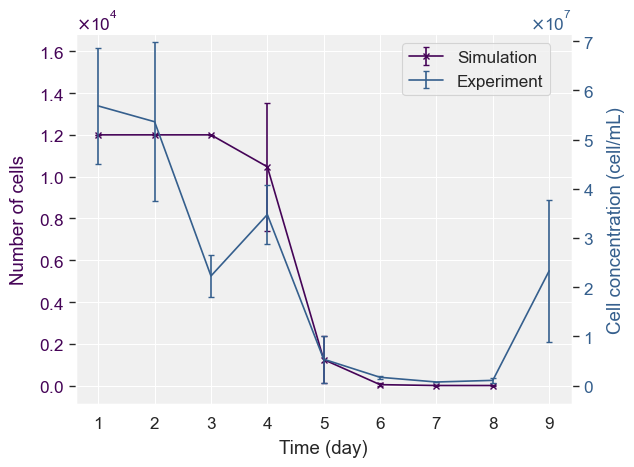

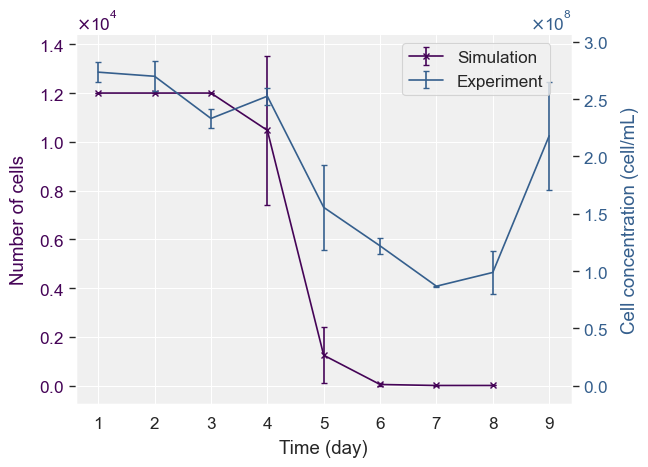

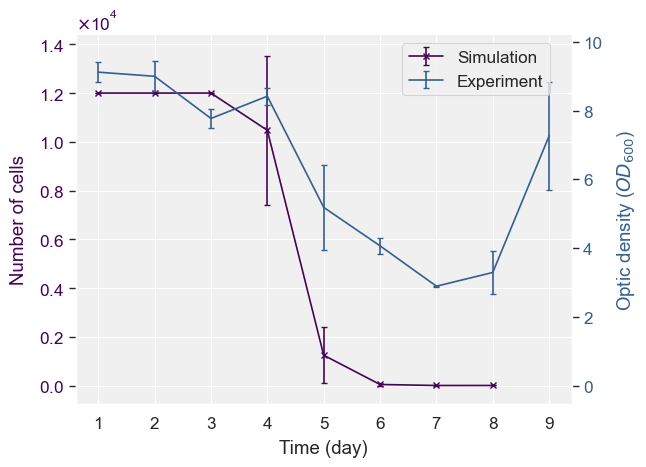

<Figure size 640x480 with 0 Axes>

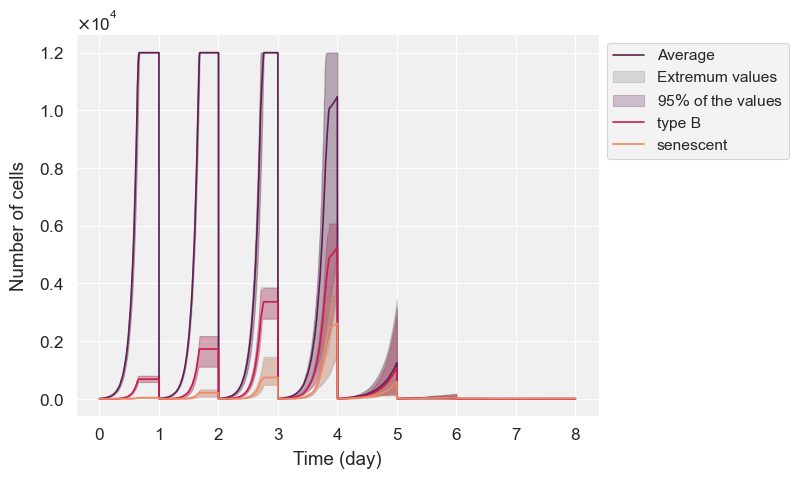

<Figure size 640x480 with 0 Axes>

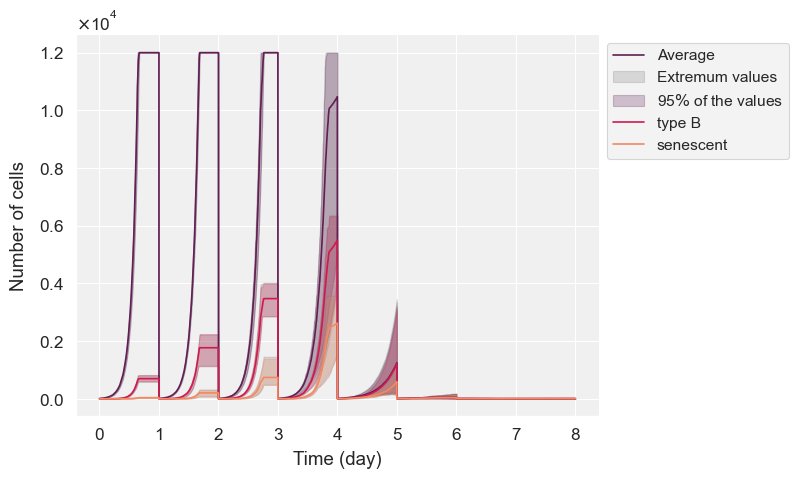

<Figure size 640x480 with 0 Axes>

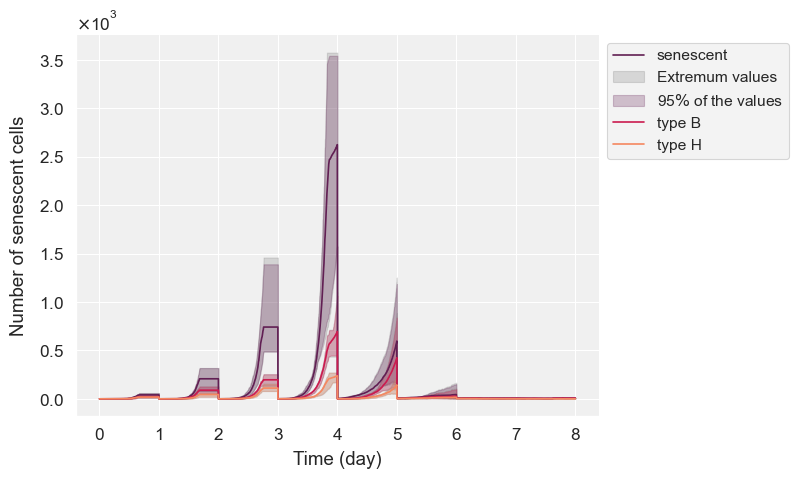

<Figure size 640x480 with 0 Axes>

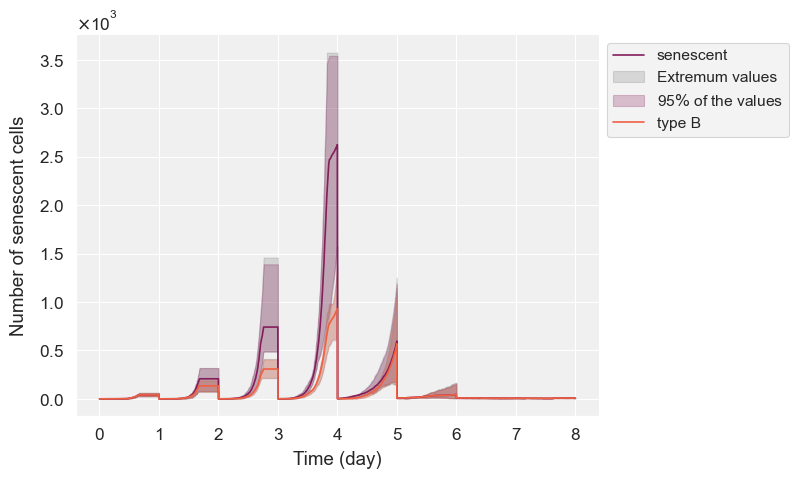

<Figure size 640x480 with 0 Axes>

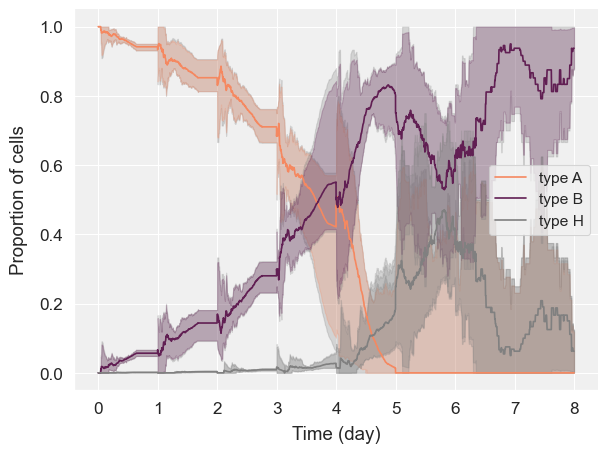

<Figure size 640x480 with 0 Axes>

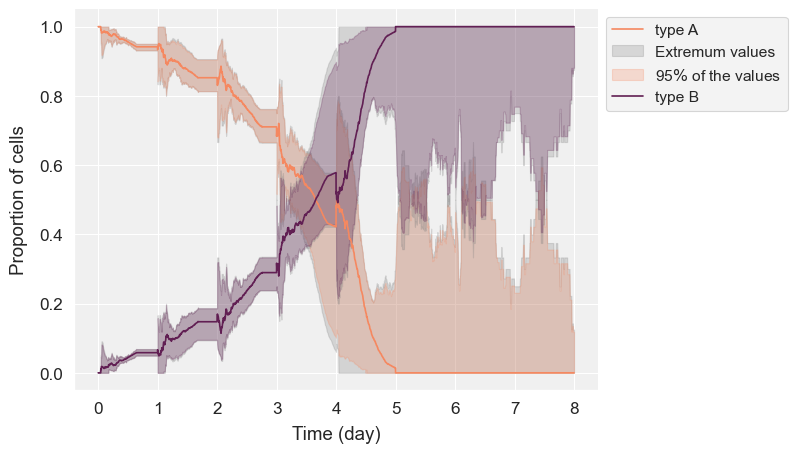

<Figure size 640x480 with 0 Axes>

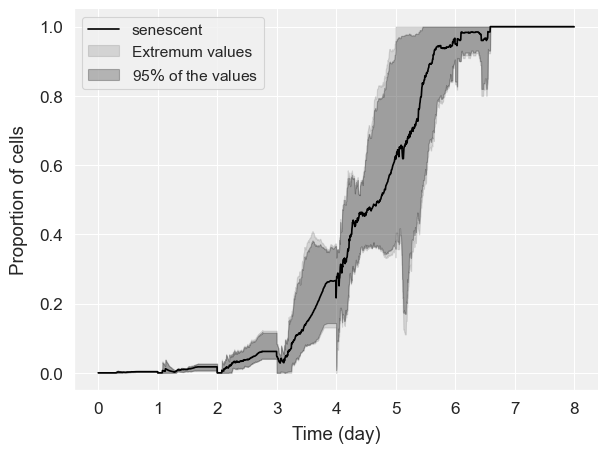

<Figure size 640x480 with 0 Axes>

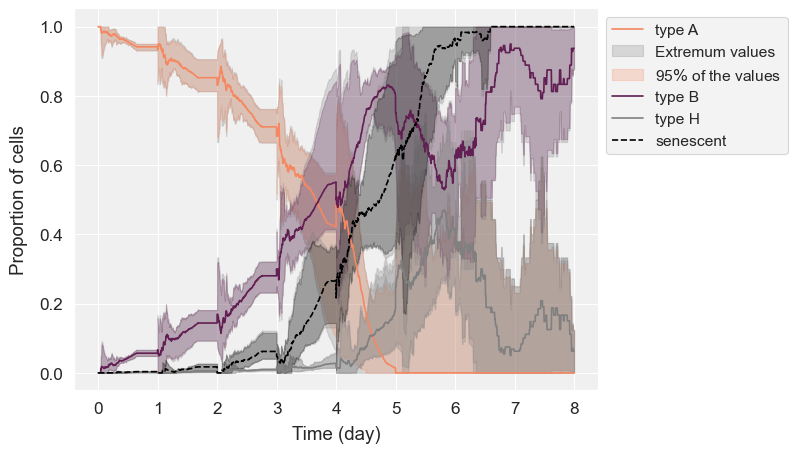

<Figure size 640x480 with 0 Axes>

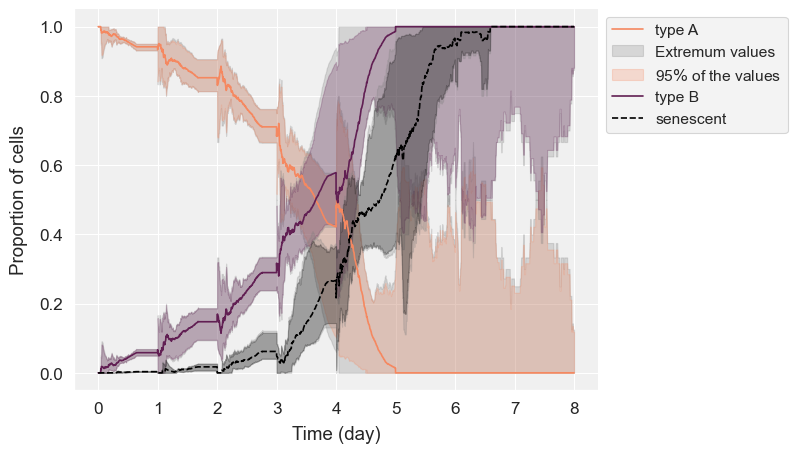

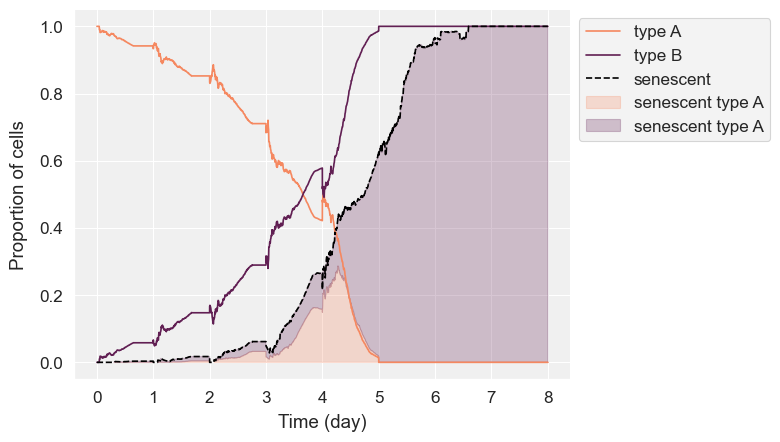

<Figure size 640x480 with 0 Axes>

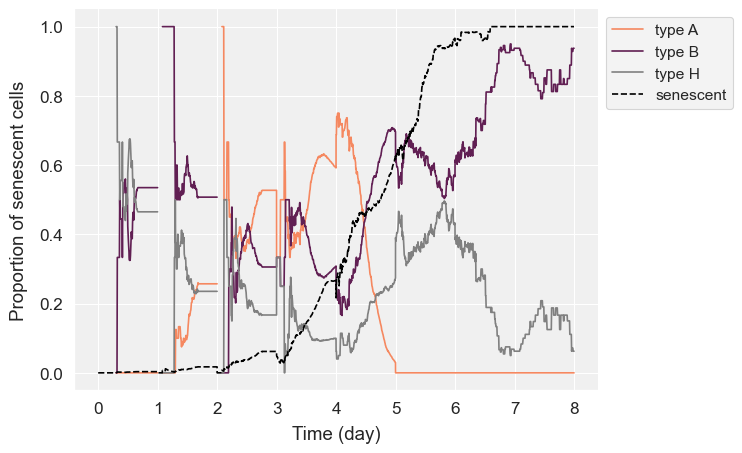

<Figure size 640x480 with 0 Axes>

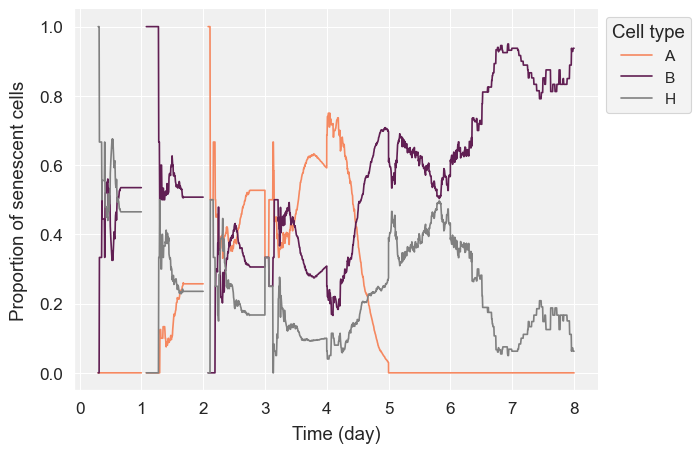

<Figure size 640x480 with 0 Axes>

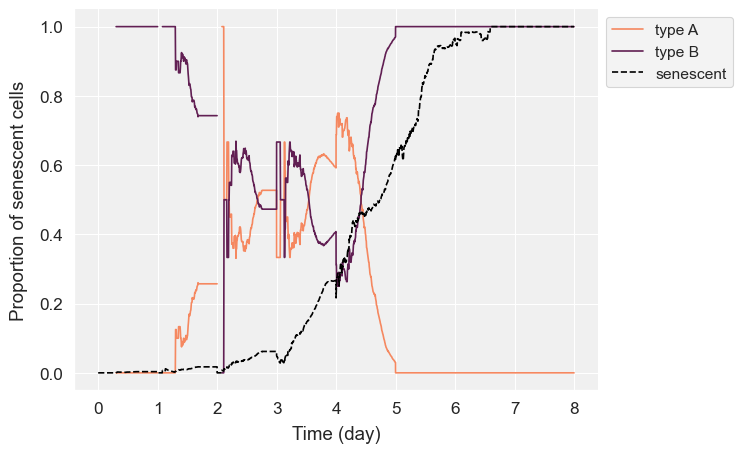

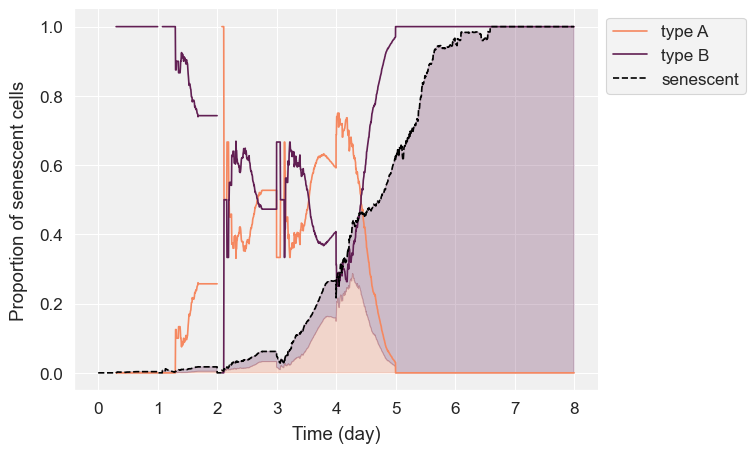

In [76]:
# Plot average on simulations run at `CELL_COUNT` and `PARA_COUNT` fixed.
TMAX_TO_PLOT = 8  # Maximum day plotted.

pp.plot_evo_c_n_p_pcfixed_from_stat(CELL_COUNT, PARA_COUNT, SIMULATION_COUNT, FIG_DIRECTORY, TMAX_TO_PLOT)

Besides looking at the structure of the population with respect to the cell type and state, one can focus on the population structure w.r.t. initia# Population structure with respect to the cell generation
pp.plot_evo_gen_pcfixed_from_stat(CELL_COUNT, PARA_COUNT, SIMULATION_COUNT, FIG_DIRECTORY, TMAX_TO_PLOT)l ancestor or generation.

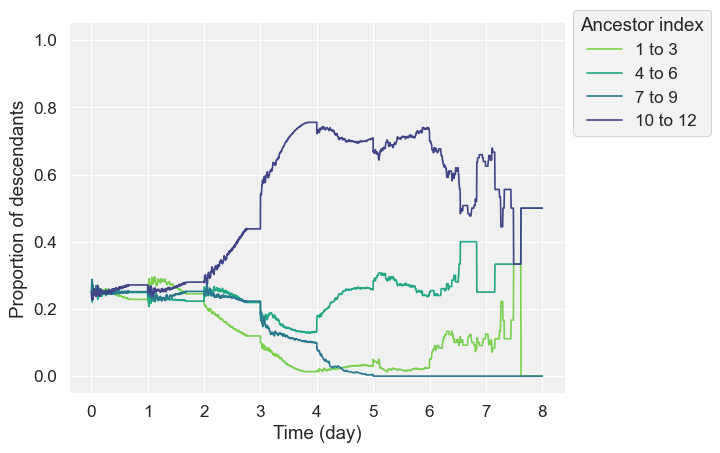

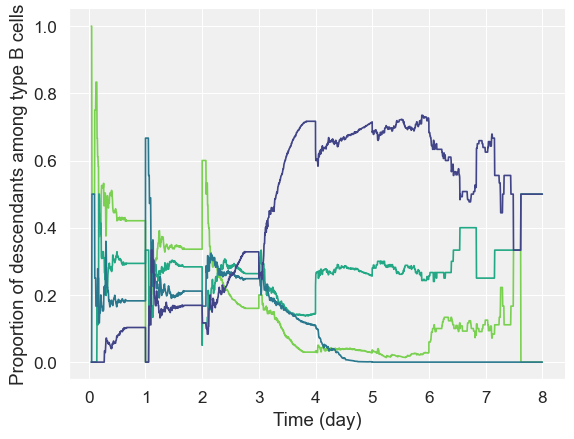

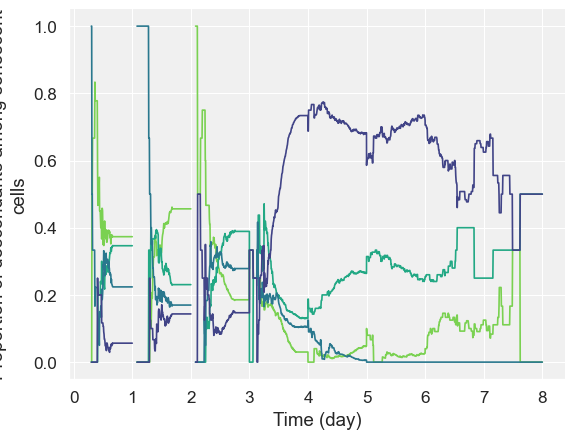

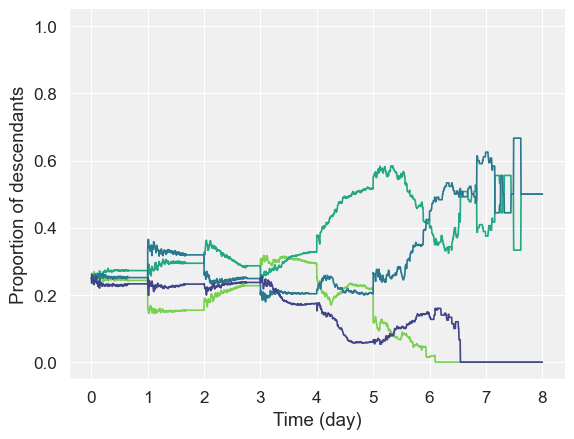

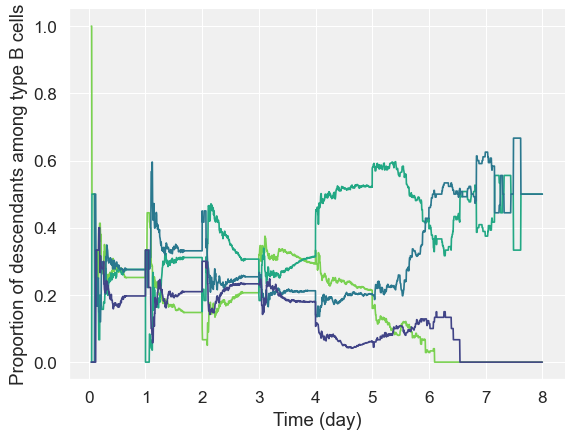

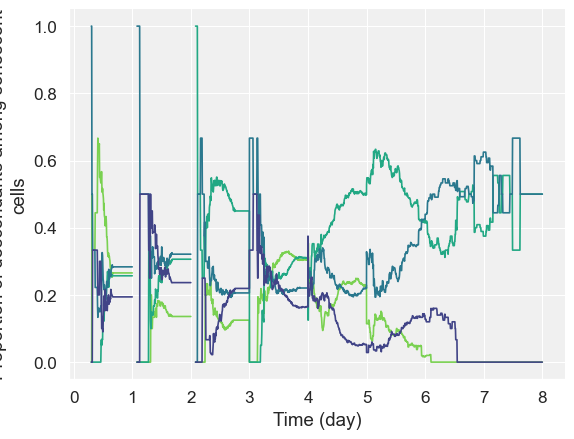

In [79]:
# Population structure with respect to the initial ancestor group.
ANC_GROUP_COUNT = 4  # Number of groups of initial ancestor (at most `CELL_COUNT`).
pp.plot_evo_p_anc_pcfixed_from_stat(CELL_COUNT, PARA_COUNT, SIMULATION_COUNT, ANC_GROUP_COUNT, FIG_DIRECTORY, TMAX_TO_PLOT)

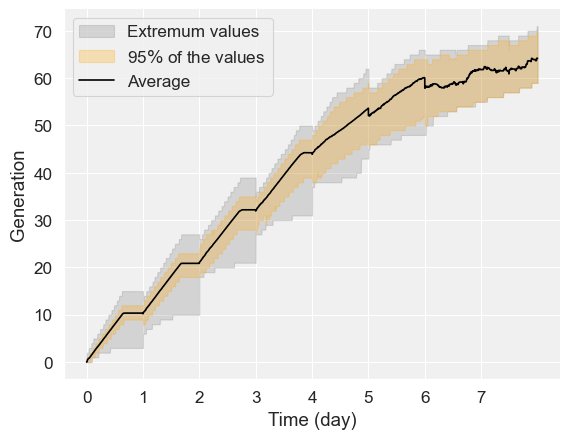

In [81]:
# Population structure with respect to the cell generation
pp.plot_evo_gen_pcfixed_from_stat(CELL_COUNT, PARA_COUNT, SIMULATION_COUNT, FIG_DIRECTORY, TMAX_TO_PLOT)

#### Evolution of telomere lengths

<Figure size 640x480 with 0 Axes>

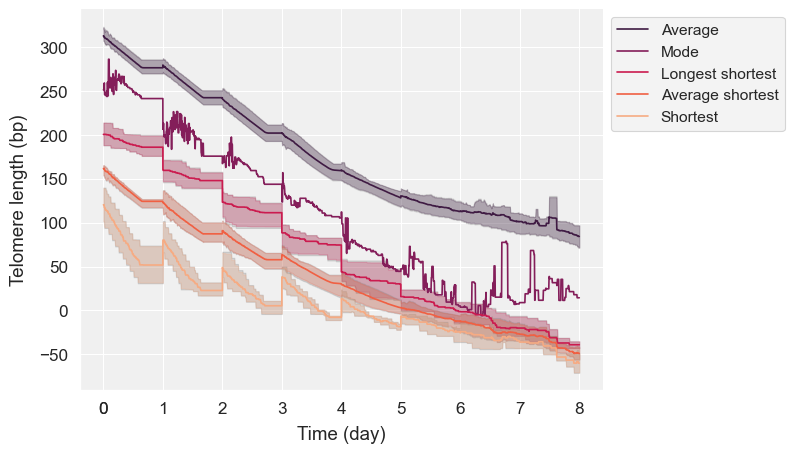

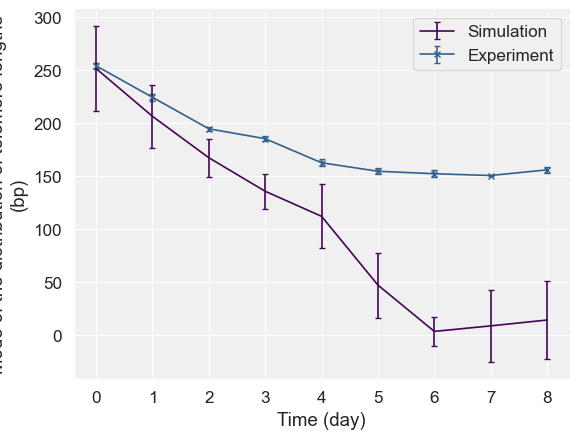

In [84]:
pp.plot_evo_l_pcfixed_from_stat(CELL_COUNT, PARA_COUNT, SIMULATION_COUNT, FIG_DIRECTORY, TMAX_TO_PLOT)

## Comparison of average simulations of different parameters

### Sensitivity to the initial number of cells

First, we run the simulations for different $N_{init}$.
For each value $N_{init}$ we run several simulations having same parameters, and posttreat them to retrieve an "average" evolution.

In [87]:
FIG_DIRECTORY = None  # Figure not saved.

CELL_COUNTS = np.array([3, 6, 12])  # Varying values for N_init.
SIMULATION_COUNTS = np.array([5, 5, 5])  # Corresponding number of simulations to run.
PARA_COUNT = 1  # (Common) number of paralelization per simulation.

for i in range(len(CELL_COUNTS)):  # Iteration on all values of N_init.
    for idx_sim in range(1, SIMULATION_COUNTS[i] + 1):  # At N_init fixed, repeat simulations sequentially.
        # Print simulation index to keep track of computation progress.
        print('\n', f'N_init = {CELL_COUNTS[i]}, simulation n° {idx_sim}/{SIMULATION_COUNTS[i]}')
    
        # Simulation and saving of the `idx_sim`-th simulation.
        # Note: No `par_update` and `par_sim_update` specified => default parameters used.
        sim.simu_parallel(PARA_COUNT, CELL_COUNTS[i], output_index=idx_sim)
                    
        # Post-treatment of the simulation.
        pps.postreat_from_evo_c(PARA_COUNT, CELL_COUNTS[i], idx_sim)
        
    # Postreatment of the set of simulations.
    out_p = pps.postreat_performances(PARA_COUNT, CELL_COUNTS[i], SIMULATION_COUNTS[i])
    out_s = pps.statistics_simus(PARA_COUNT, CELL_COUNTS[i], SIMULATION_COUNTS[i])



 N_init = 3, simulation n° 1/5
Day n° 1 c_last 3
Day n° 2 c_last 3.0
Day n° 3 c_last 3.0
Day n° 4 c_last 3.0
Day n° 5 c_last 3.0
Day n° 6 c_last 3.0
Day n° 7 c_last 3.0
Saved at:  /home/anais/Documents/python/telomeres/simulations/population/parNTA0.0247947389-0.440063202_parSENA0.186824276-0.725200993-27_parSENB2.45423414e-06-0.122028128-0/psat1000/pdeath0.0043-0.58_prepair0.65/linit0-40-58/cell_3/para_1/output_01.npy

 N_init = 3, simulation n° 2/5
Day n° 1 c_last 3
Day n° 2 c_last 3.0
Day n° 3 c_last 3.0
Day n° 4 c_last 3.0
Day n° 5 c_last 3.0
Day n° 6 c_last 3.0
Day n° 7 c_last 3.0
Saved at:  /home/anais/Documents/python/telomeres/simulations/population/parNTA0.0247947389-0.440063202_parSENA0.186824276-0.725200993-27_parSENB2.45423414e-06-0.122028128-0/psat1000/pdeath0.0043-0.58_prepair0.65/linit0-40-58/cell_3/para_1/output_02.npy

 N_init = 3, simulation n° 3/5
Day n° 1 c_last 3
Day n° 2 c_last 3.0
Day n° 3 c_last 3.0
Day n° 4 c_last 3.0
Day n° 5 c_last 3.0
Day n° 6 c_last 3.0
Sa

Then, processed outputs can be plotted using directly already mmade plotting functions (see `main.population.plot.py` for more plotting functions).

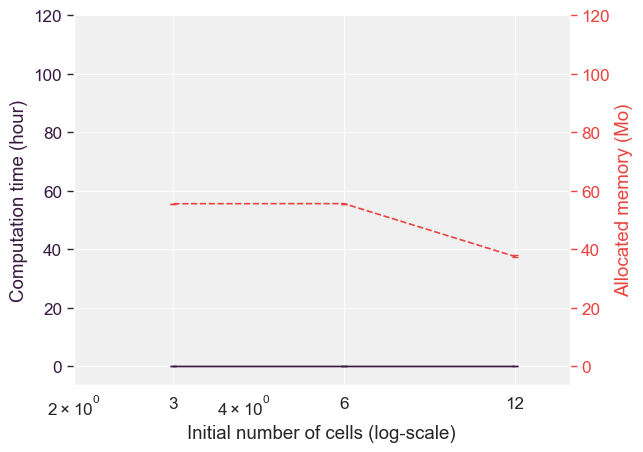

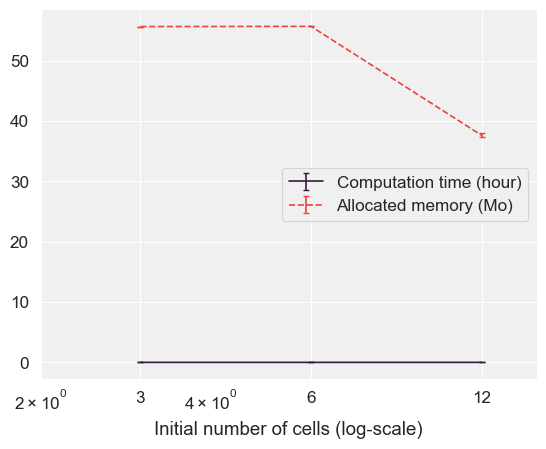

<Figure size 640x480 with 0 Axes>

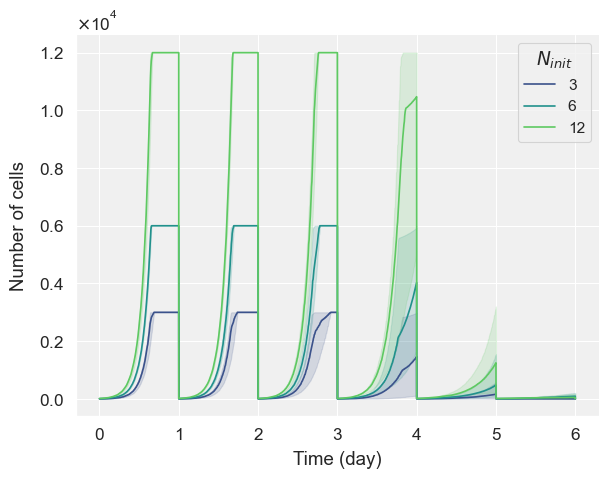

<Figure size 640x480 with 0 Axes>

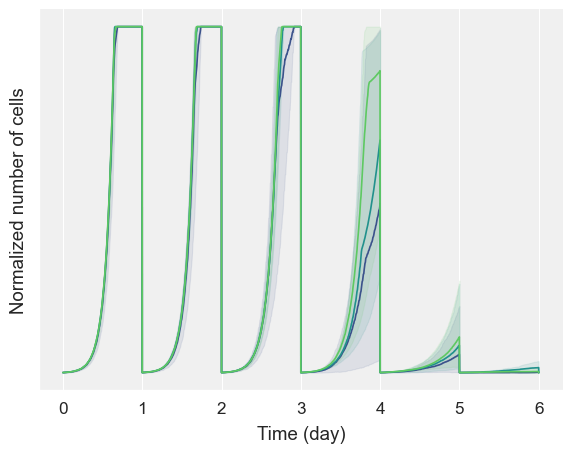

<Figure size 640x480 with 0 Axes>

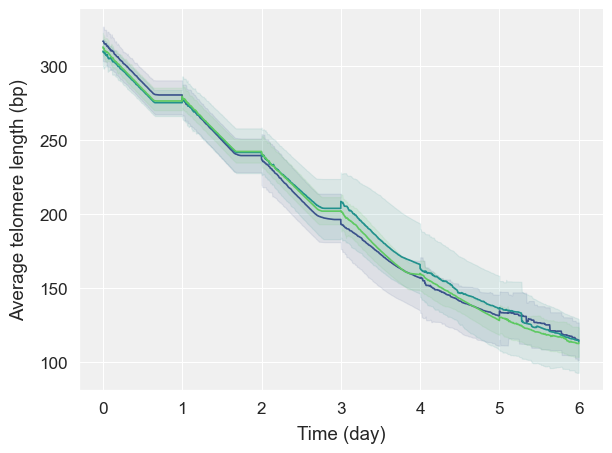

<Figure size 640x480 with 0 Axes>

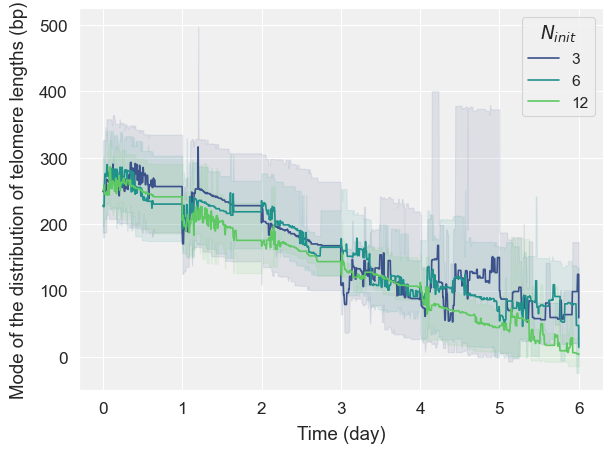

<Figure size 640x480 with 0 Axes>

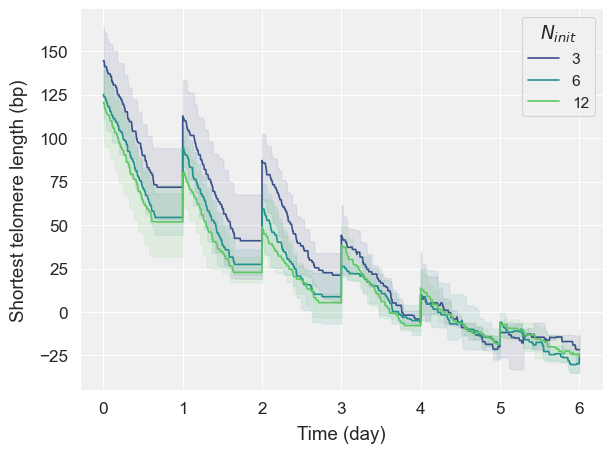

<Figure size 640x480 with 0 Axes>

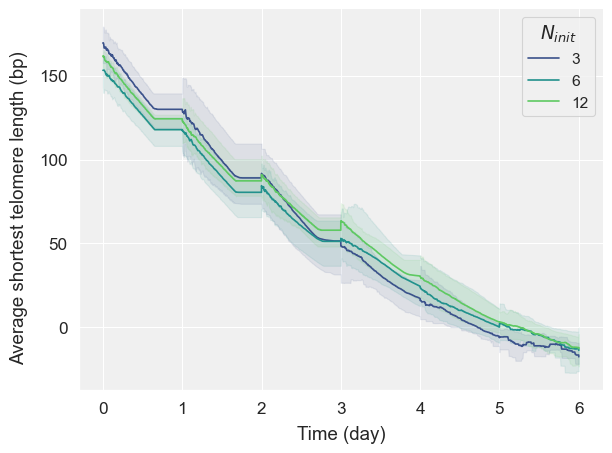

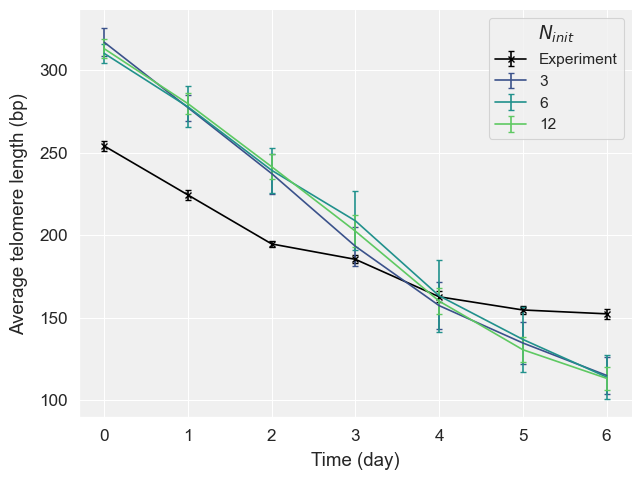

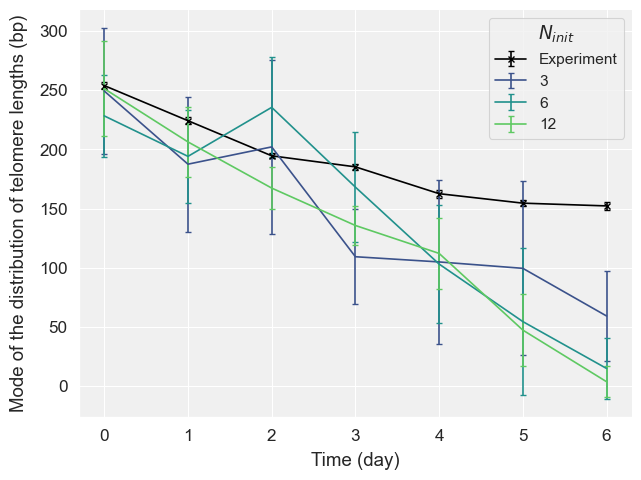

<Figure size 640x480 with 0 Axes>

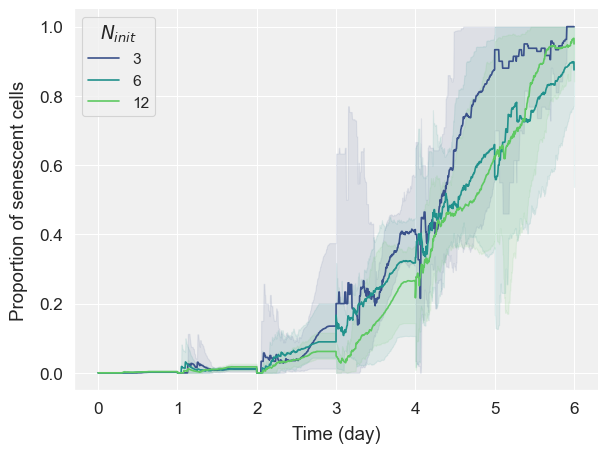

<Figure size 640x480 with 0 Axes>

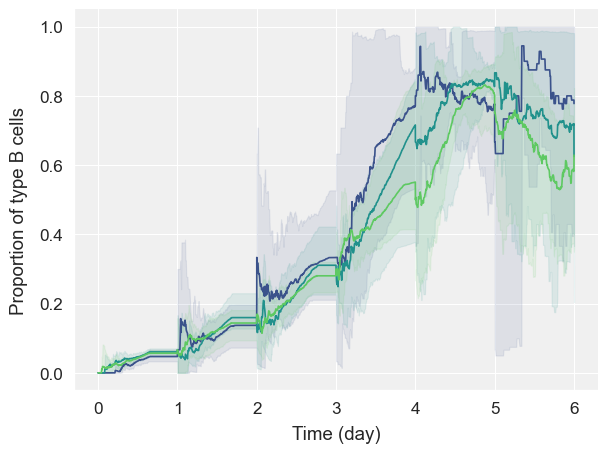

<Figure size 640x480 with 0 Axes>

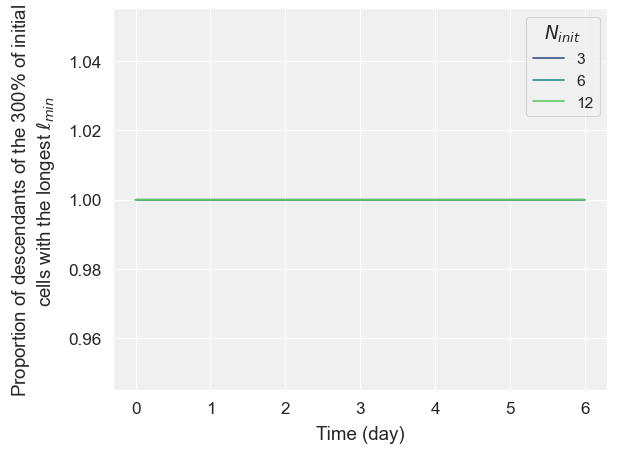

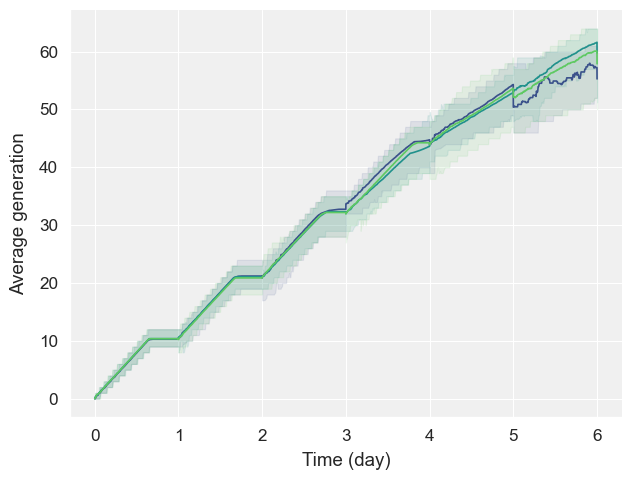

In [91]:
# Plot some outputs to compare the sets of simulations.
TMAX_TO_PLOT = 6
ANC_GROUP_COUNT = CELL_COUNTS[0]
pp.plot_performances_pfixed(CELL_COUNTS, SIMULATION_COUNTS, FIG_DIRECTORY, para_count=PARA_COUNT)
pp.plot_evo_pfixed(CELL_COUNTS, SIMULATION_COUNTS, ANC_GROUP_COUNT, FIG_DIRECTORY, TMAX_TO_PLOT)

### Sensitivity to model parameters

To test the sensitivity to a certain parameter of the model:
- First, run the simulations
- Then, use `plot_evo_w_variable` to plot the results (different graphs in one, corresponding to different parameter values).

See `main.population.plot.py` for various examples.

> **Example 1. Sensitivity to $p_{accident}$.**

In [94]:
# Simulation parameters.
PARA_COUNT = 1
CELL_COUNT = 12
SIMULATION_COUNT = 5

# Model parameters: definition of the various new values for `p_accident`.
P_ACC_S = par.P_ACCIDENT * np.array([1., 25, 50.])
VARYING_KEY = 'accident'  # The key 'accident of the dictionnary of parameters is the one to be varied.
P_EXIT_TMP = deepcopy(par.P_EXIT)
PAR_UPDATES = []  # List of `par_update` to use for simulation.
for p_acc in P_ACC_S:
    P_EXIT_TMP[VARYING_KEY] = p_acc
    PAR_UPDATES.append({'p_exit': deepcopy(P_EXIT_TMP)})

# Simulations.
for i in range(len(P_ACC_S)):  # Iteration on all values of `p_accident`.
    for idx_sim in range(1, SIMULATION_COUNT + 1):  # At `p_accident` fixed, repeat simulations sequentially.
        # Print simulation index to keep track of computation progress.
        print('\n', f"p_accident = {PAR_UPDATES[i]['p_exit']['accident']}, simulation n° {idx_sim}/{SIMULATION_COUNT}")
    
        # Simulation and saving of the `idx_sim`-th simulation.
        # Note: `par_update` must be specified! otherwise default parameters used.
        sim.simu_parallel(PARA_COUNT, CELL_COUNT, output_index=idx_sim, par_update=PAR_UPDATES[i])
       
        # Post-treatment of the simulation.
        pps.postreat_from_evo_c(PARA_COUNT, CELL_COUNT, idx_sim, par_update=PAR_UPDATES[i])
        
    # Postreatment of the set of simulations.
    out_p = pps.postreat_performances(PARA_COUNT, CELL_COUNT, SIMULATION_COUNT, par_update=PAR_UPDATES[i])
    out_s = pps.statistics_simus(PARA_COUNT, CELL_COUNT, SIMULATION_COUNT, par_update=PAR_UPDATES[i])


 p_accident = 0.0043, simulation n° 1/5
Loaded from:  /home/anais/Documents/python/telomeres/simulations/population/parNTA0.0247947389-0.440063202_parSENA0.186824276-0.725200993-27_parSENB2.45423414e-06-0.122028128-0/psat1000/pdeath0.0043-0.58_prepair0.65/linit0-40-58/cell_12/para_1/output_01.npy

 p_accident = 0.0043, simulation n° 2/5
Loaded from:  /home/anais/Documents/python/telomeres/simulations/population/parNTA0.0247947389-0.440063202_parSENA0.186824276-0.725200993-27_parSENB2.45423414e-06-0.122028128-0/psat1000/pdeath0.0043-0.58_prepair0.65/linit0-40-58/cell_12/para_1/output_02.npy

 p_accident = 0.0043, simulation n° 3/5
Loaded from:  /home/anais/Documents/python/telomeres/simulations/population/parNTA0.0247947389-0.440063202_parSENA0.186824276-0.725200993-27_parSENB2.45423414e-06-0.122028128-0/psat1000/pdeath0.0043-0.58_prepair0.65/linit0-40-58/cell_12/para_1/output_03.npy

 p_accident = 0.0043, simulation n° 4/5
Loaded from:  /home/anais/Documents/python/telomeres/simulatio

<Figure size 640x480 with 0 Axes>

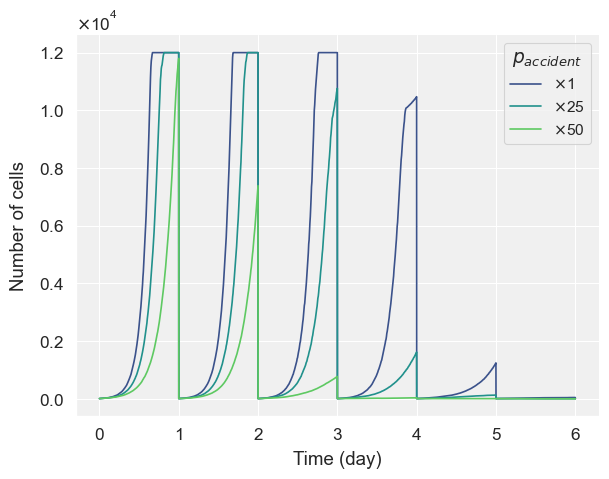

<Figure size 640x480 with 0 Axes>

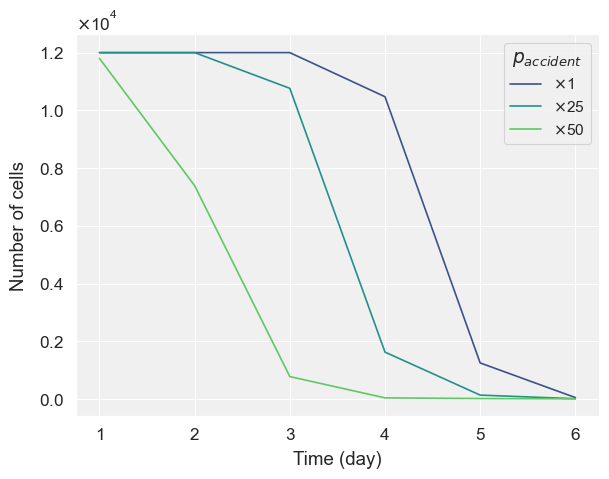

<Figure size 640x480 with 0 Axes>

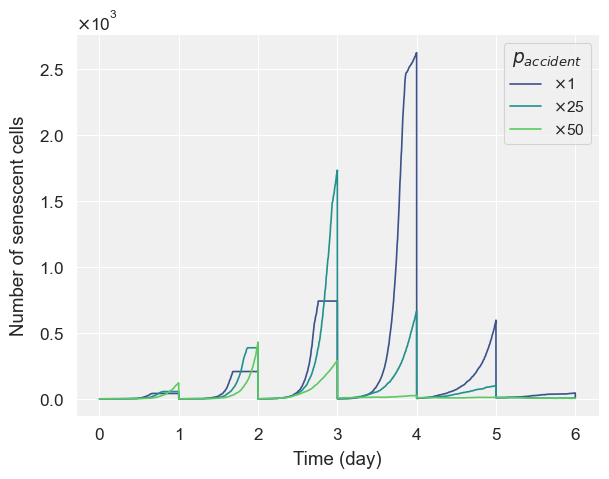

<Figure size 640x480 with 0 Axes>

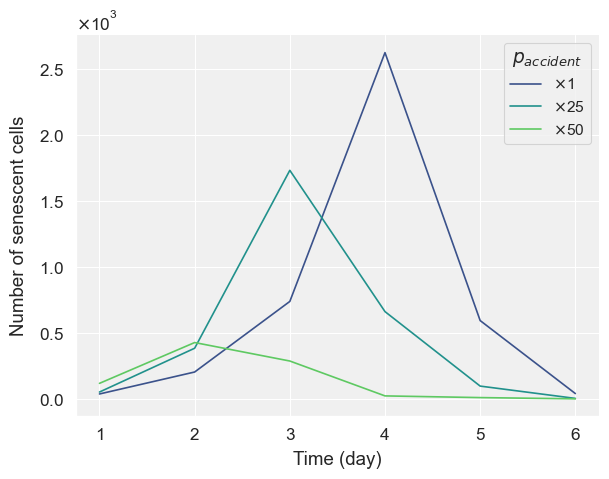

<Figure size 640x480 with 0 Axes>

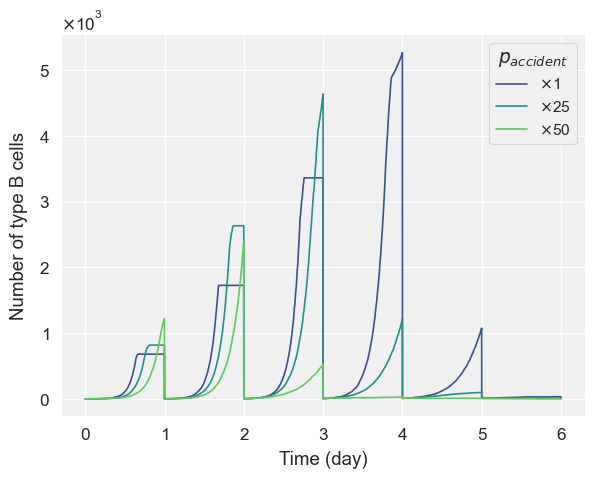

<Figure size 640x480 with 0 Axes>

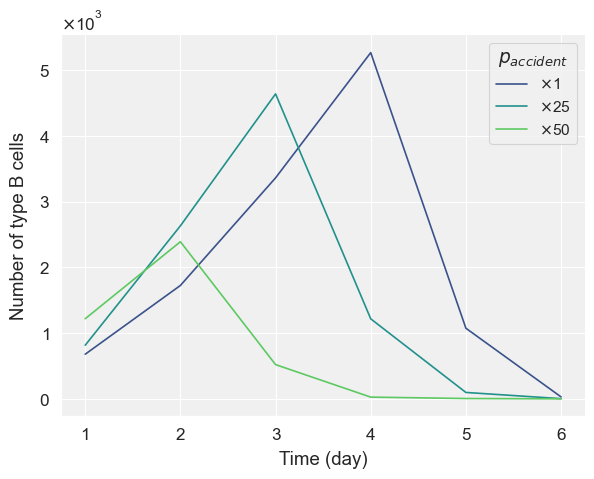

<Figure size 640x480 with 0 Axes>

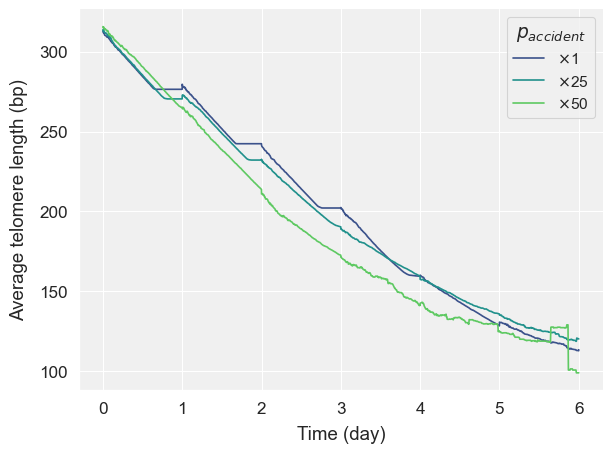

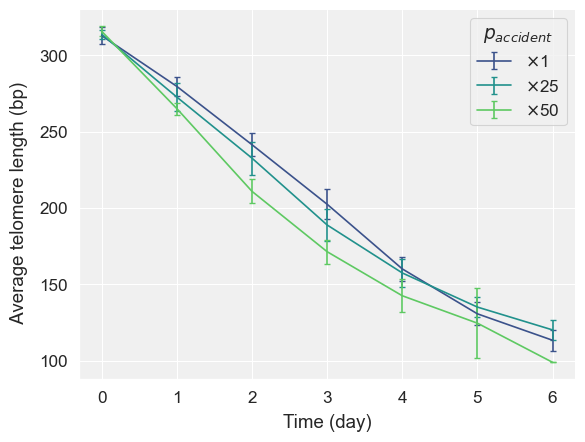

<Figure size 640x480 with 0 Axes>

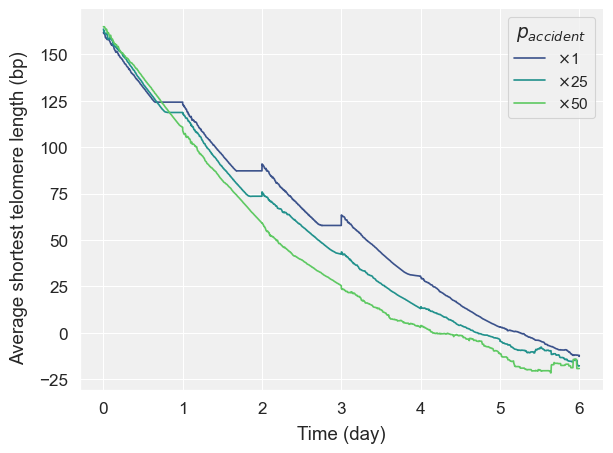

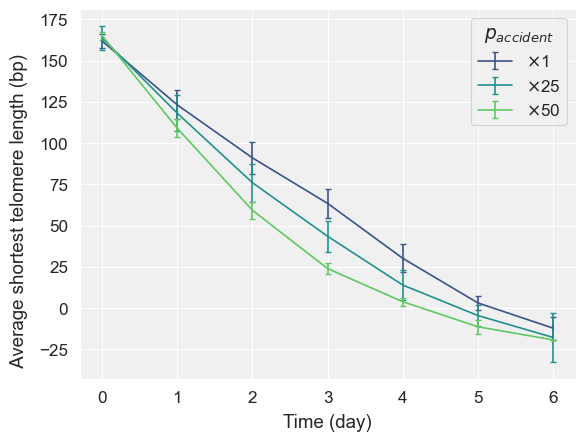

<Figure size 640x480 with 0 Axes>

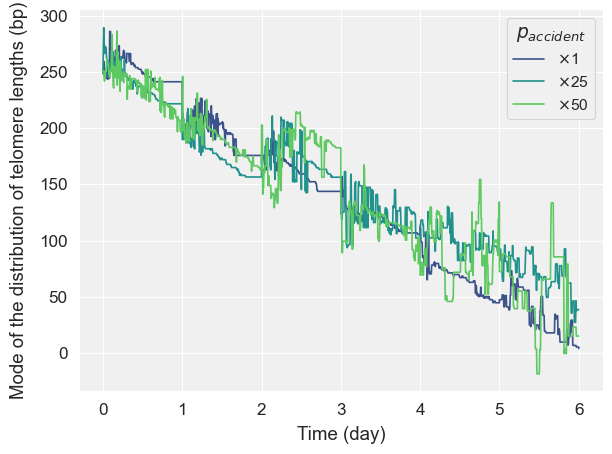

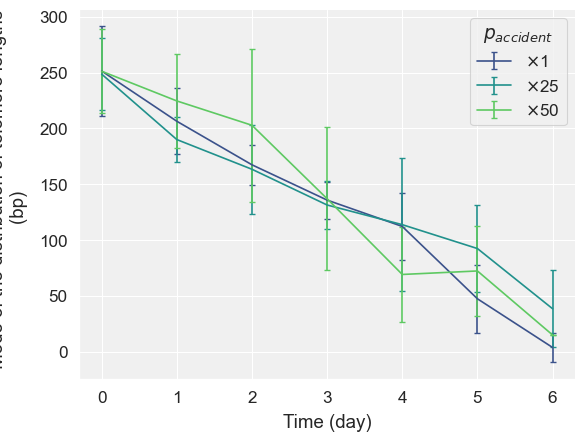

<Figure size 640x480 with 0 Axes>

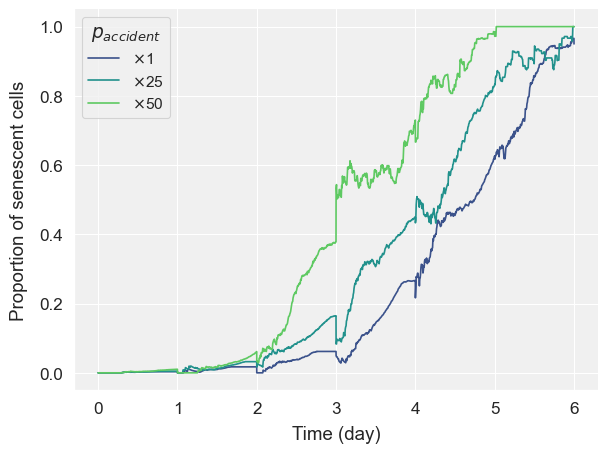

<Figure size 640x480 with 0 Axes>

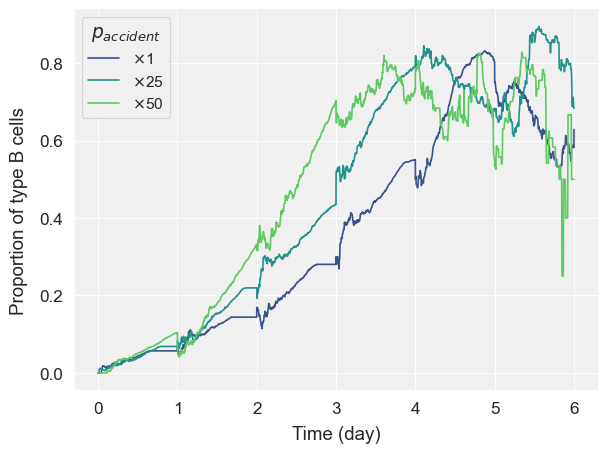

<Figure size 640x480 with 0 Axes>

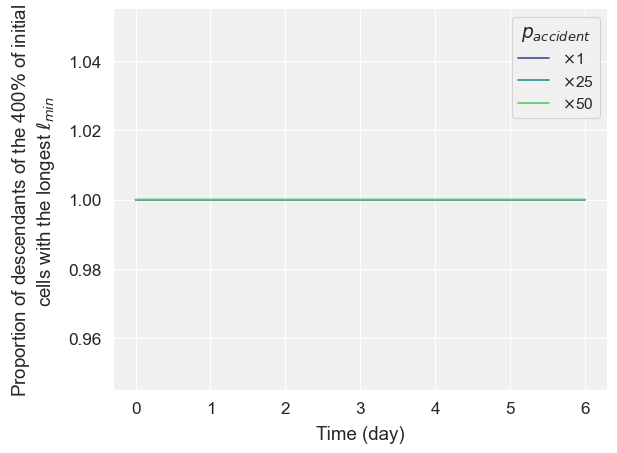

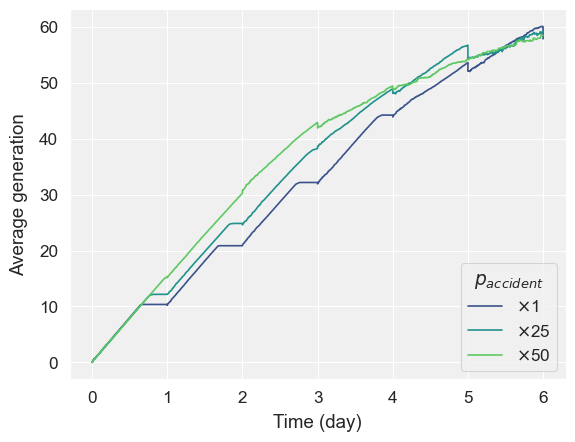

In [97]:
# Plotting parameter.
ANC_GROUP_COUNT = 4
T_MAX = 6
CURVE_LABELS = [r'$\times$' + str(int(p_acc / P_ACC_S[0])) for p_acc in P_ACC_S]
FIG_DIR = None  # Figure not saved

# Plot the results.
pp.plot_evo_w_variable(CELL_COUNT, PARA_COUNT, SIMULATION_COUNT, PAR_UPDATES, VARYING_KEY,
                       CURVE_LABELS, ANC_GROUP_COUNT, FIG_DIR, T_MAX, is_interpolated=False)